# On-line Bayesian state estimation for real-time monitoring of growth kinetics with pulsed laser deposition

### Sumner B. Harris

###10/08/24

This notebook provides the ParamEstim class which is uses the direct filter method of parameter estimation [1] to get the growth and nucleation rate constants of thin films during PLD growth. This example assumes the data is laser reflectivity, and uses the built-in "monolayer model" to show how this estimation method works for our PLD data.


[1] Archibald, R., Bao, F. & Tu, X. A direct filter method for parameter estimation. Journal of Computational Physics 398, 108871 (2019). https://doi.org/https://doi.org/10.1016/j.jcp.2019.108871

## Build the ParamEstim class

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class ParamEstim():
    """
    A class for parameter estimation using the direct filter method.

    This class implements the direct filter method for estimating model parameters
    based on measurements obtained over time. It supports built-in models, 
    such as the monolayer model, and allows for the incorporation of measurement noise.

    Attributes:
        model_type (str): Type of the model being used (e.g., 'monolayer').
        initial_guess (np.ndarray): Initial guess for model parameters.
        sigma (float): Measurement noise standard deviation.
        eta (np.ndarray): Measurement noise variance.
        num_particles (int): Number of particles in the filter.
        stop_time (float): Time at which to stop exploration.
        stop_contrast (float): Reflected contrast at which to stop exploration.
        particles (np.ndarray): Array of particles representing the parameter distribution.
        predictions (list): List of predicted parameters after each estimation step.
        uncertainties (list): List of uncertainties for the predicted parameters.
        time (np.ndarray): Array to hold time data.
        measurements (np.ndarray): Array to hold measurement data.
    """
    def __init__(self,
                 model_type=None,
                 initial_guess=None,
                 sigma=0.01, eta=None,
                 num_particles=1000,
                 stop_time=None,
                 stop_contrast=None,
                 custom_model=None,
                 custon_model_num_params=None):

        #built-in models
        self.model_methods = {
            'monolayer': [self.monolayer_model,2],
            #bilayer': [self.bilayer_model,4], # not implemented yet
            #'trilayer': [self.trilayer_model,6] # not implemented yet
            }
        
        valid_model_types = self.model_methods.keys()


        if model_type is not None:
            if model_type not in valid_model_types:
                raise ValueError(f"Invalid model_type: '{model_type}'. Must be one of {valid_model_types}.")
            self.model_type = model_type
            self.current_model = self.model_methods[model_type][0]
            self.num_model_params = self.model_methods[model_type][1]
        else:
            # Handle custom model if required
            #self.current_model = custom_model
            #self.num_model_params = custon_model_num_params
            raise NotImplementedError("Custom models are not implemented yet.")

        self.num_particles = num_particles
        
        if initial_guess is None:
            self.theta0 = np.zeros(self.num_model_params)
        else:
            self.theta0 = initial_guess
        
        # Set measurement noise (default: small value)
        if eta is None:
            self.eta = np.ones(self.num_model_params) * 5.0e-4
        else:
            self.eta = eta

        if stop_time is not None and stop_contrast is not None:
            raise ValueError("Both 'stop_time' and 'stop_value' cannot be provided at the same time.")
            
        self.stop_time = stop_time
        self.stop_contrast = stop_contrast

        self.sigma = sigma
        
        self.particles = np.abs(np.random.multivariate_normal(self.theta0, np.diag(np.sqrt(self.eta)), self.num_particles))
        self.predictions = []
        self.uncertainties = []
        
        self.time = np.zeros(0) # initialize empty time array
        self.measurements = np.zeros(0) # initialize empty measurement array
        
    def step_estimation(self,new_times, new_measurements):
        """Update the estimation with new times and measurements."""
        # update time, measurement arrays with new data
        self._update_data(new_times, new_measurements)
        
        #perform a parameter estimation step on newly acquired data
        for i in tqdm(range(0,len(new_times))):
            weights = np.ones(self.num_particles)*(1/self.num_particles)
            z = new_measurements[i]
                   
            if self.stop_time is not None:
                if new_times[i]>=self.stop_time:
                    self.eta = self.eta*0
                    Rnorm_contraints = self.particles*0
                else: 
                    Rnorm_contraints = np.maximum(-self.particles,0)**2/self.eta

            if self.stop_contrast is not None:
                if new_measurements.mean()<=self.stop_contrast:
                    self.eta = self.eta*0
                    Rnorm_contraints = self.particles*0
                else: 
                    Rnorm_contraints = np.maximum(-self.particles,0)**2/self.eta

            self.particles += np.random.multivariate_normal(np.zeros(self.num_model_params), np.diag(self.eta), self.num_particles)
            
            #update -------------------------------------------------------------------------------------------
            Yhat = np.zeros(self.num_particles)
            Yhat += [self.current_model(new_times[i], *p)  for p in self.particles] 
            Yhat -= z*np.ones(self.num_particles)
        
            Rnorm = Yhat**2/self.sigma**2
            
            # stack all Rnorms
            Rnorm = np.hstack((Rnorm.reshape(-1,1),Rnorm_contraints))
    
            weights *= np.exp(-0.5*np.sum(Rnorm,axis=1))
            #weights *= np.exp(-0.5*np.sum(Rnorm))
            weights = np.nan_to_num(weights) # remove all nan values and set to 0
            weights += 1.e-300      # avoid round-off to zero
            weights /= np.sum(weights)  # normalize
        
            #resample -----------------------------------------------------------------------------------------
            indexes = self._systematic_resample(weights) 
            self.particles[:] = self.particles[indexes] 
        
            mu = np.average(self.particles,axis=0)
            std = np.std(self.particles,axis=0)
            
            self.predictions.append(mu)
            self.uncertainties.append(std)
    
    def predict(self):
        """Predict using the estimated parameters."""
        result = []
        for i in range(len(self.predictions)):
            result.append(self.current_model(self.time[i],*self.predictions[i]))
        return np.array(result)
        
    def monolayer_model(self, t, kn, kgr):
        """Monolayer model calculation."""
        f1 = -0.362 # Contrast for 1 monolayer of WSe2 on 90 nm SiO2/Si substrate
        coverage =  (kn/kgr)*(np.exp((kn+kgr)*t)-1)/(1+(kn/kgr)*np.exp((kn+kgr)*t))
        return f1*coverage
    
    def _update_data(self,new_times, new_measurements):
        """Update time and measurement arrays with new data."""
        self.time = np.append(self.time,new_times)
        self.measurements = np.append(self.measurements,new_measurements)

    def _systematic_resample(self,weights):
        """ Performs the systemic resampling algorithm used by particle filters.
        Taken from filterpy 1.4.4 https://filterpy.readthedocs.io/en/latest/
        """
        N = len(weights)

        # make N subdivisions, and choose positions with a consistent random offset
        positions = (np.random.random() + np.arange(N)) / N

        indexes = np.zeros(N, 'i')
        cumulative_sum = np.cumsum(weights)
        i, j = 0, 0
        while i < N:
            if positions[i] < cumulative_sum[j]:
                indexes[i] = j
                i += 1
            else:
                j += 1
        return indexes

## Example use with simulated in situ reflectivity data

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.79it/s]


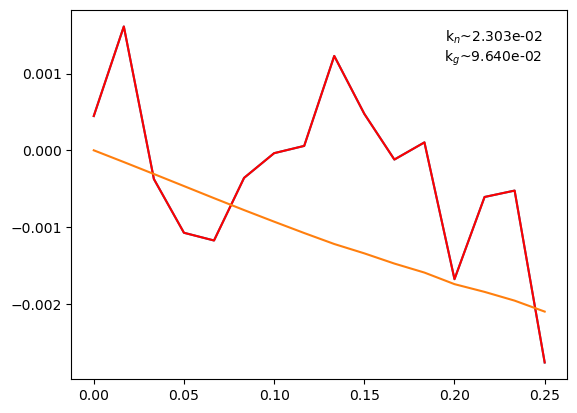

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.56it/s]


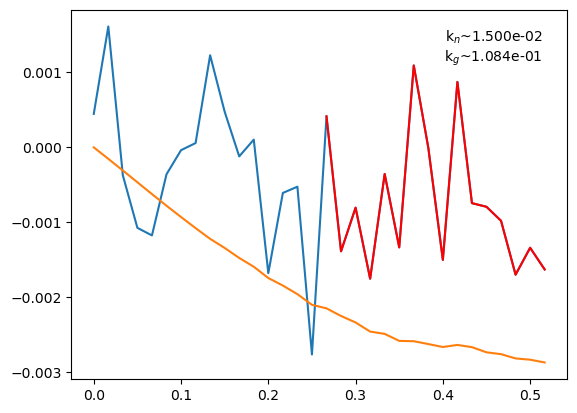

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 161.59it/s]


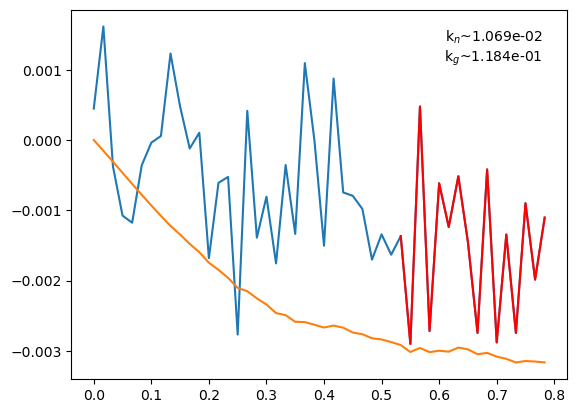

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.22it/s]


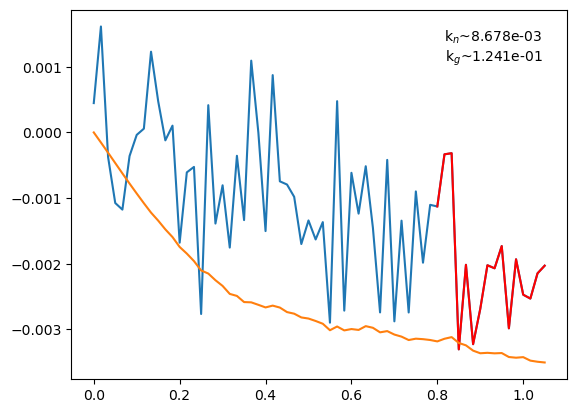

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.66it/s]


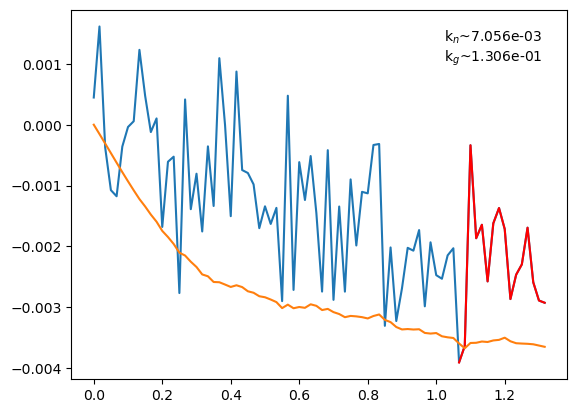

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.82it/s]


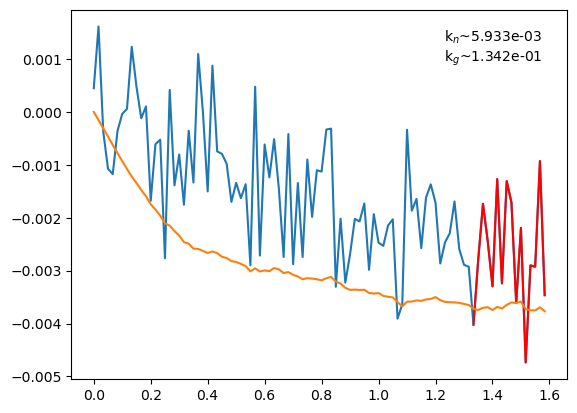

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 185.94it/s]


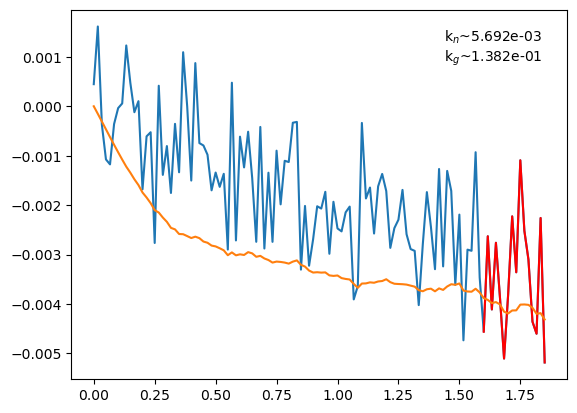

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 185.32it/s]


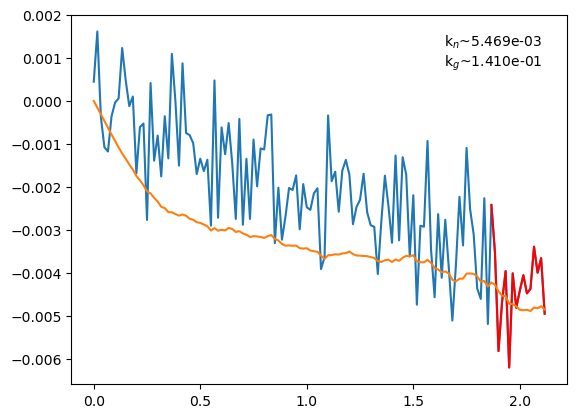

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.39it/s]


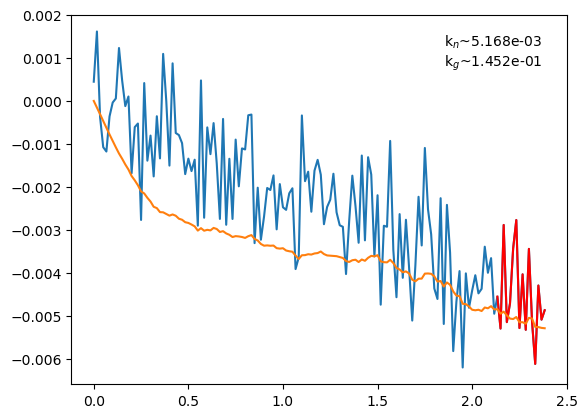

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 181.92it/s]


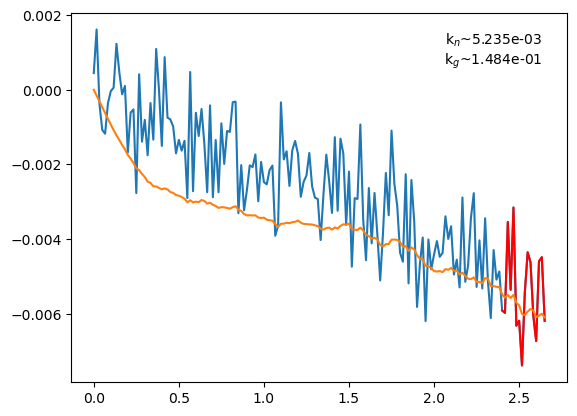

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.80it/s]


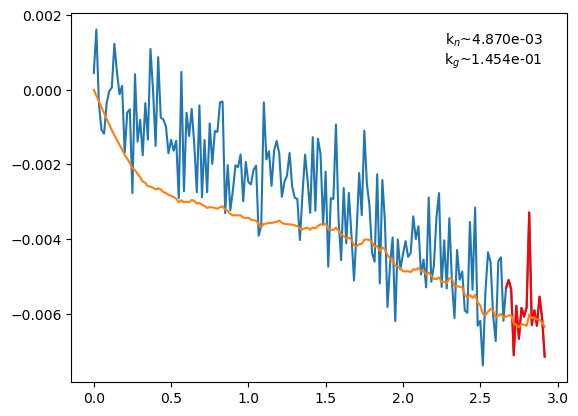

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.77it/s]


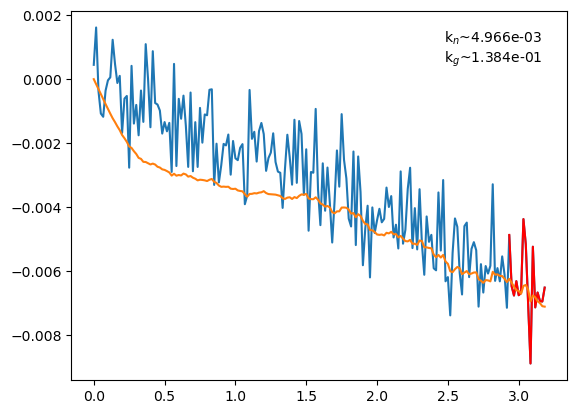

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 181.52it/s]


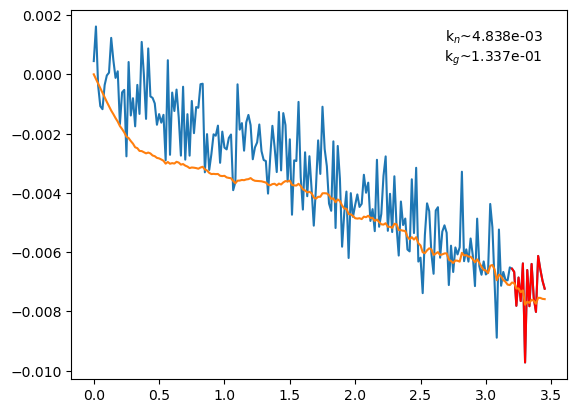

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.04it/s]


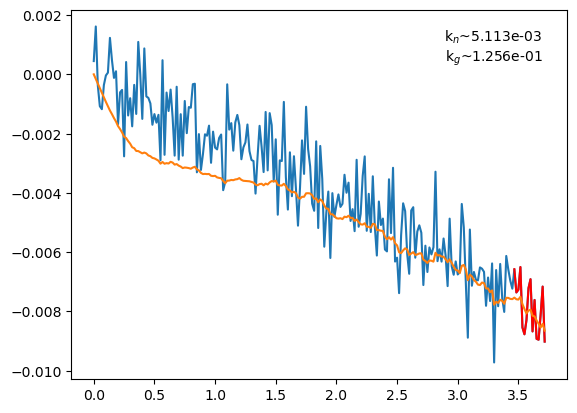

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 164.92it/s]


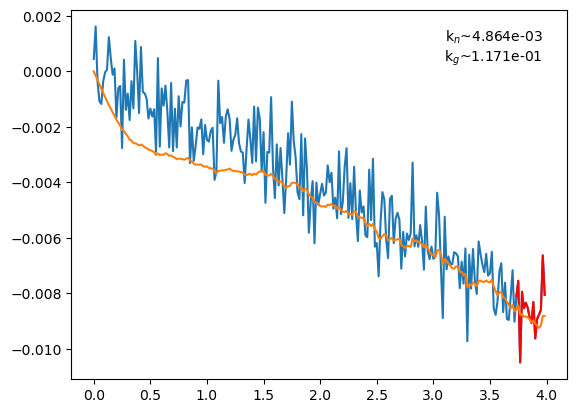

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.21it/s]


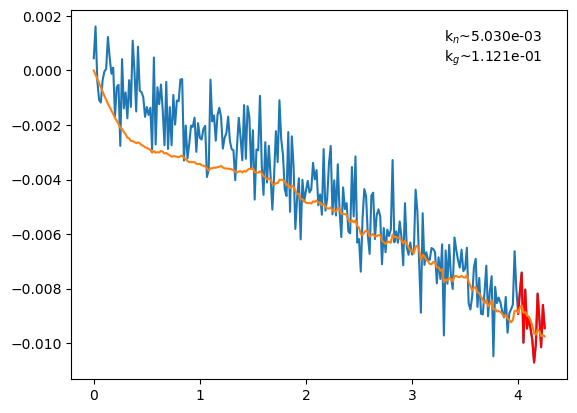

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.79it/s]


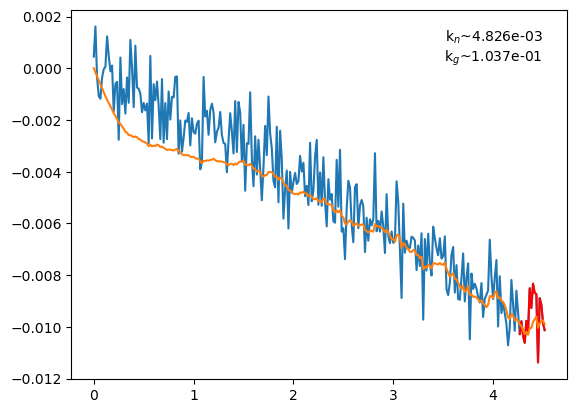

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 183.87it/s]


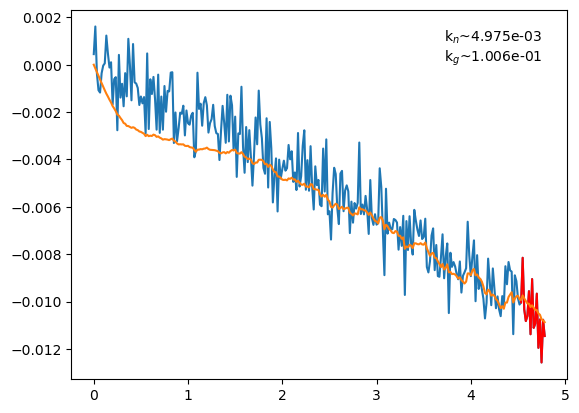

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.74it/s]


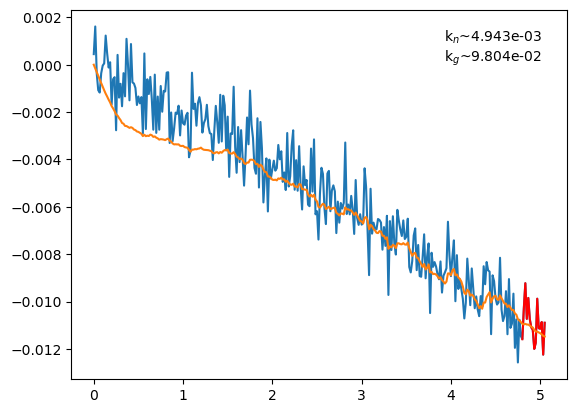

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.75it/s]


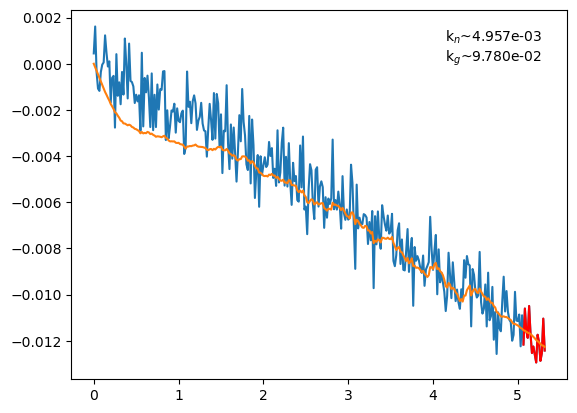

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 183.88it/s]


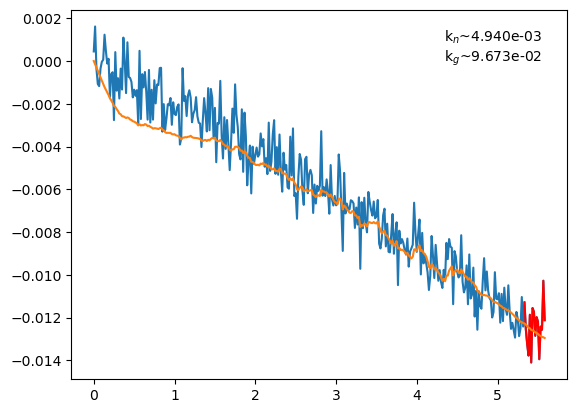

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.74it/s]


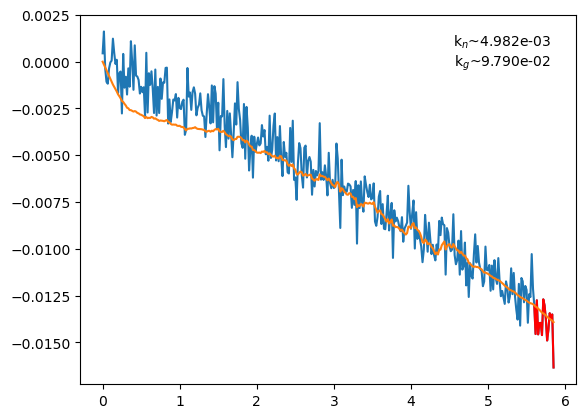

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.75it/s]


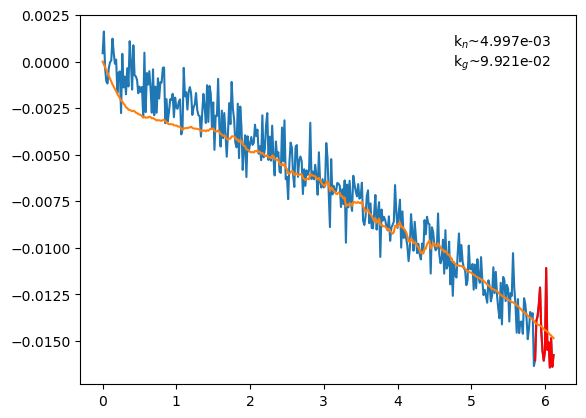

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.74it/s]


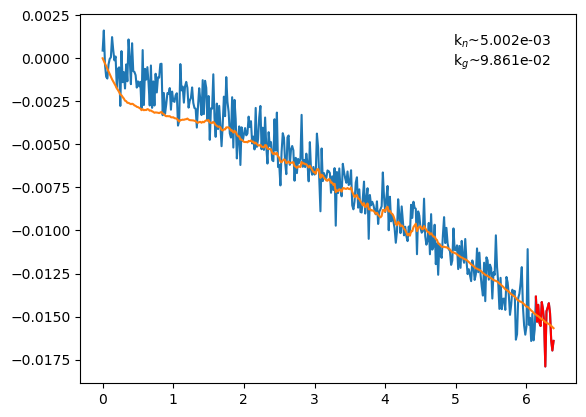

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.80it/s]


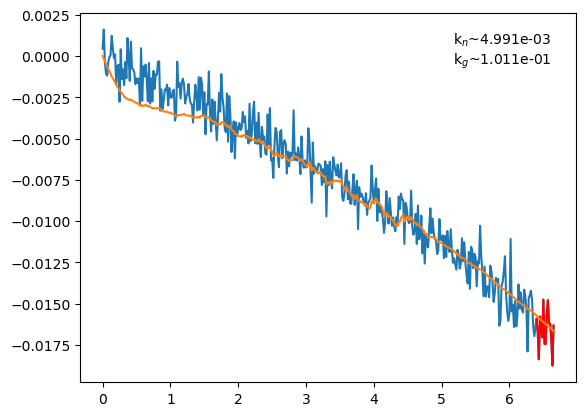

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.74it/s]


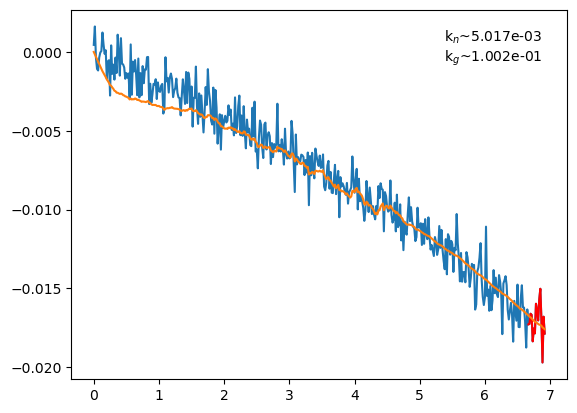

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.75it/s]


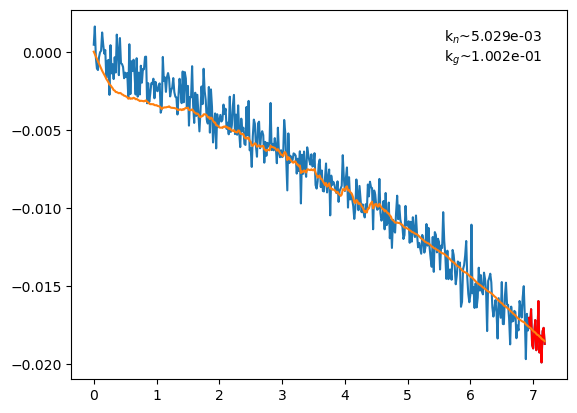

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.75it/s]


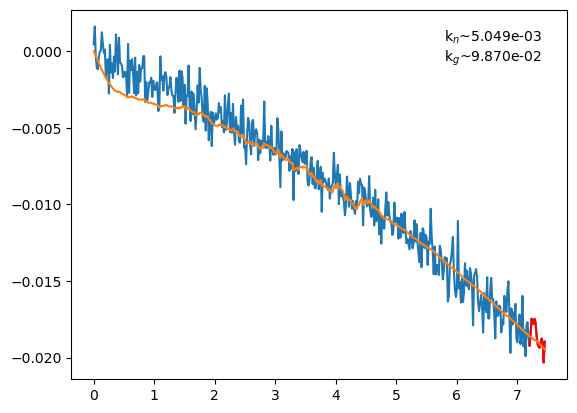

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 181.79it/s]


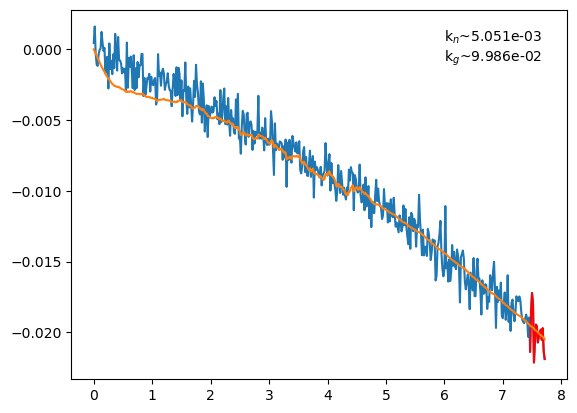

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.68it/s]


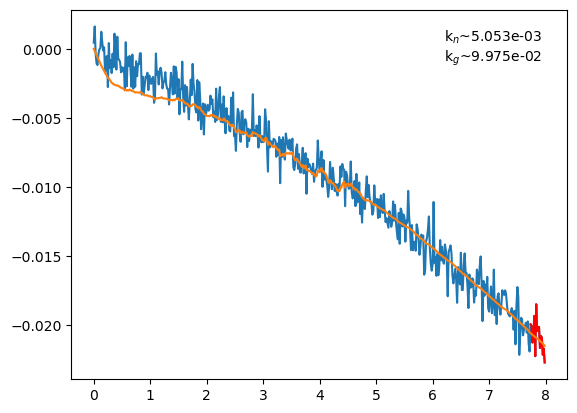

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 180.84it/s]


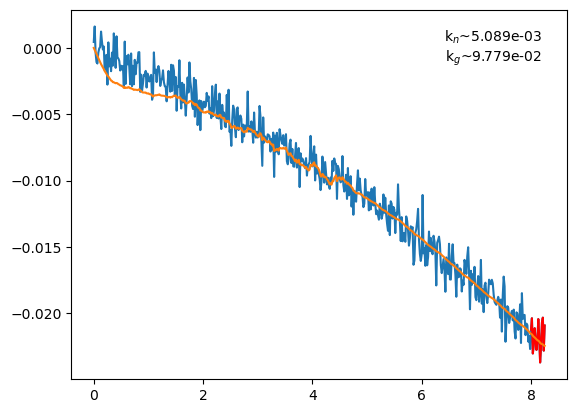

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.72it/s]


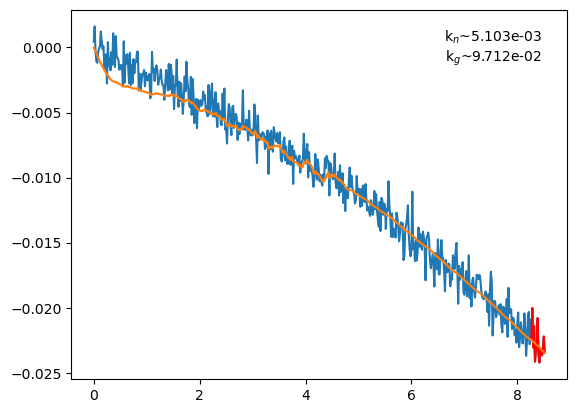

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 183.78it/s]


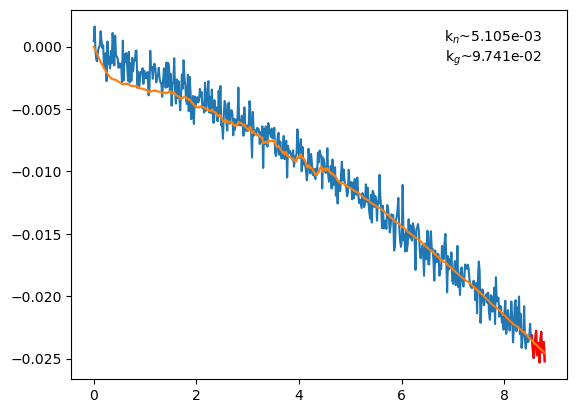

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.67it/s]


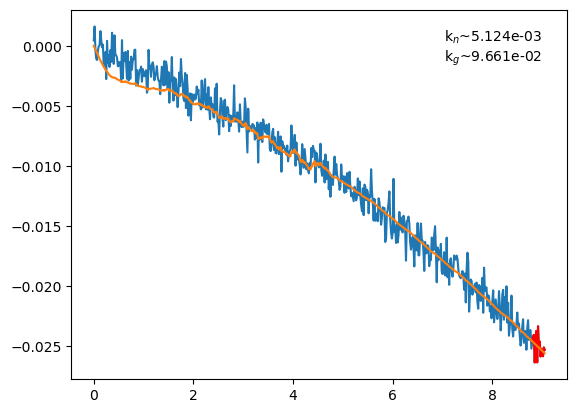

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.12it/s]


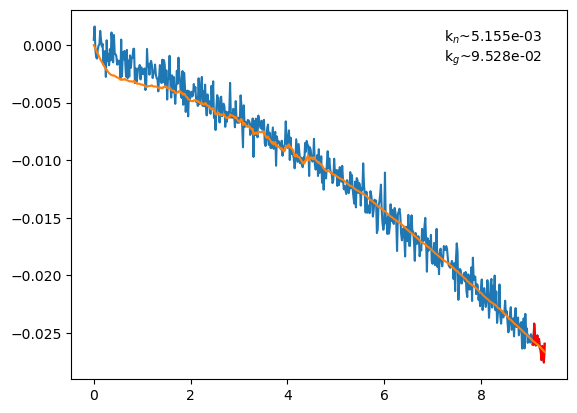

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.68it/s]


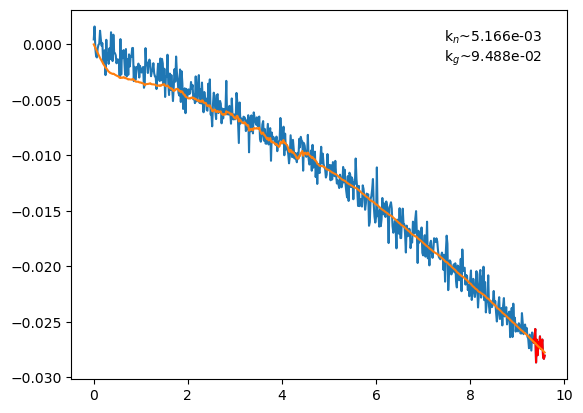

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 180.12it/s]


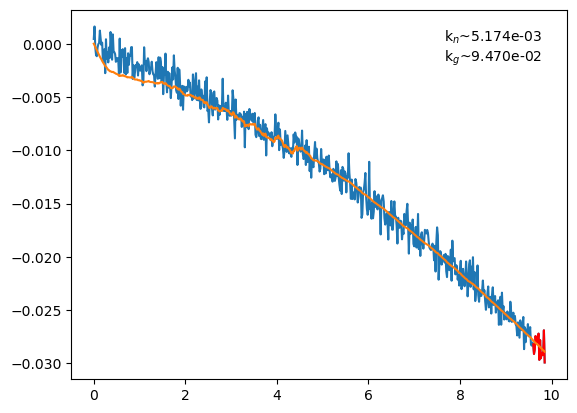

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 183.80it/s]


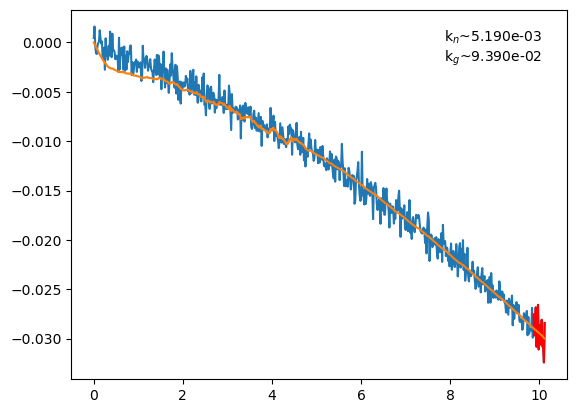

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.76it/s]


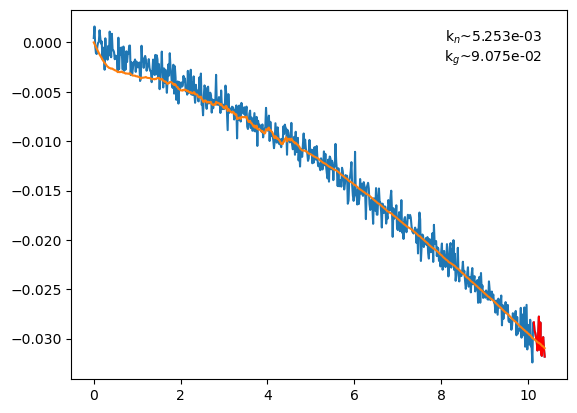

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 133.25it/s]


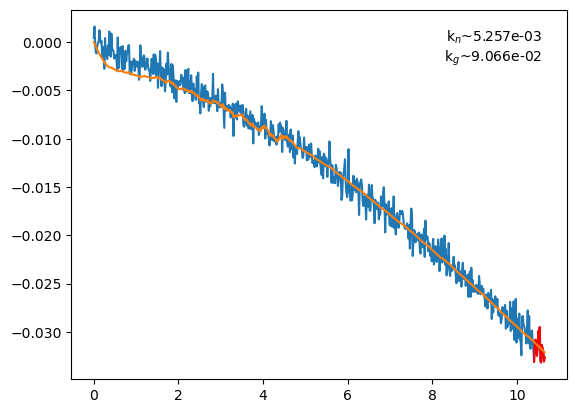

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.67it/s]


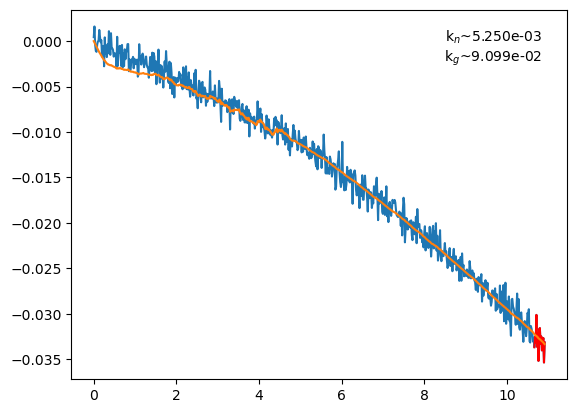

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.83it/s]


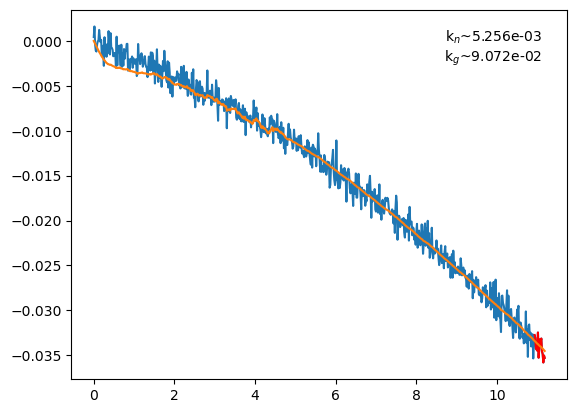

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.43it/s]


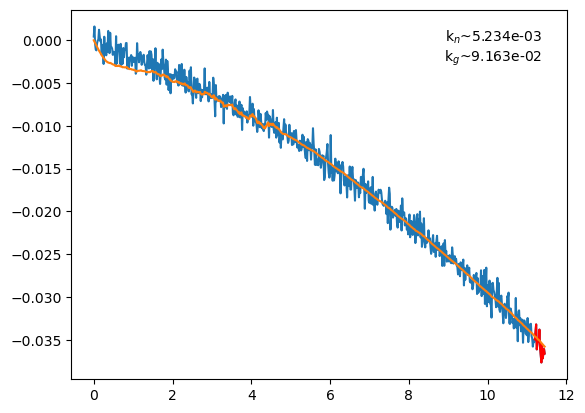

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.67it/s]


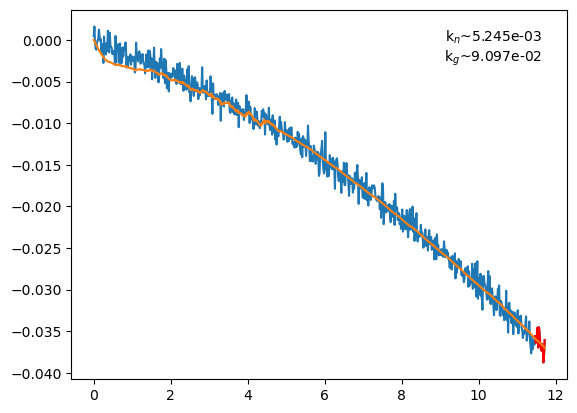

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.62it/s]


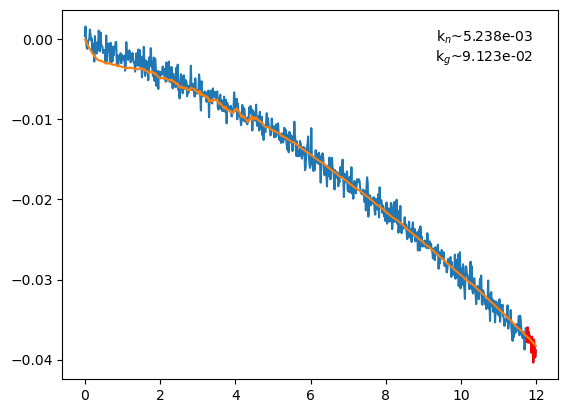

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.81it/s]


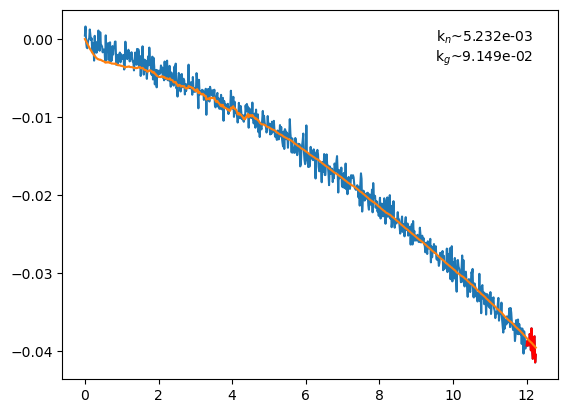

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.75it/s]


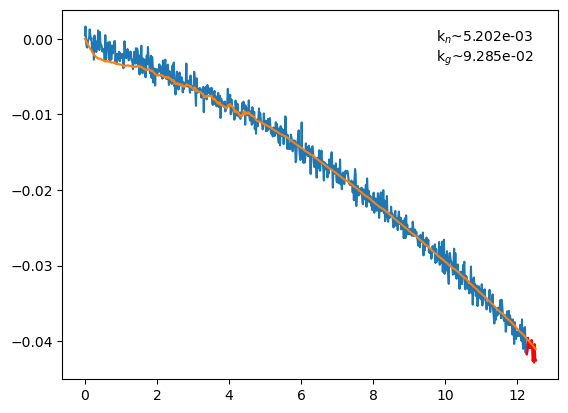

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.87it/s]


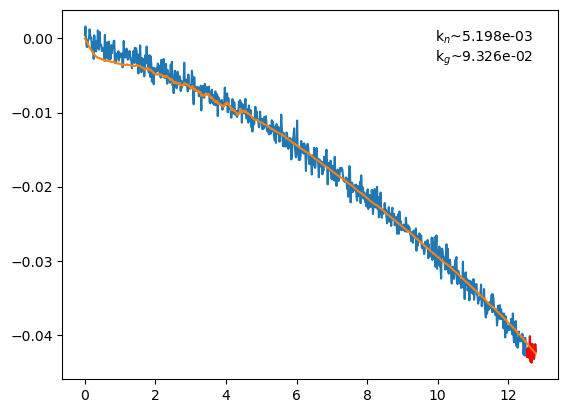

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.75it/s]


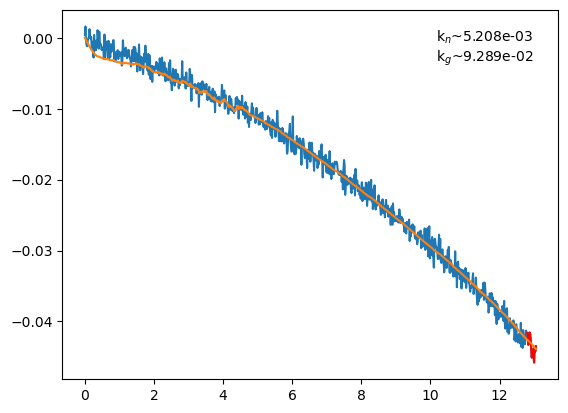

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.40it/s]


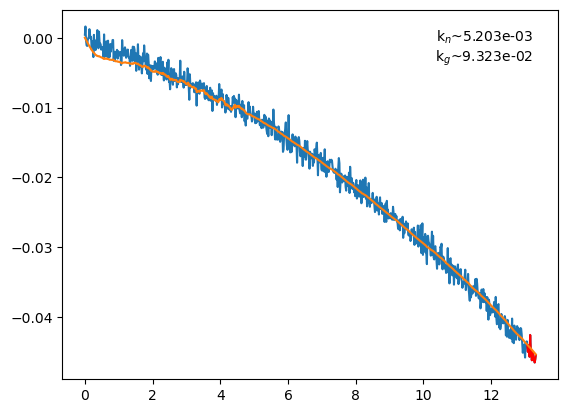

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.89it/s]


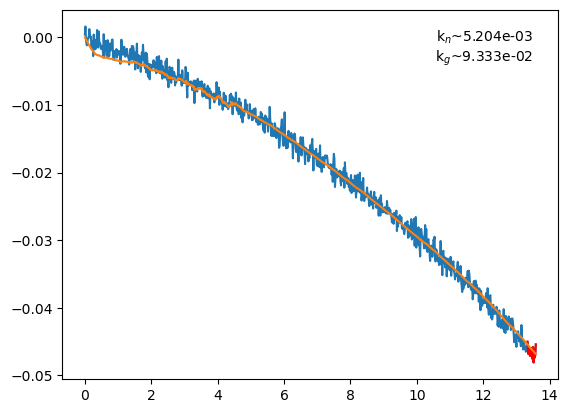

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.88it/s]


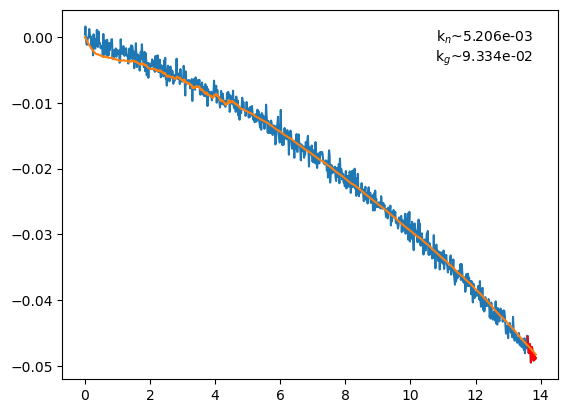

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 181.70it/s]


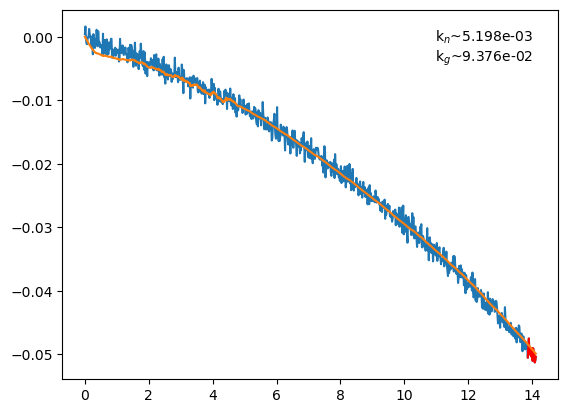

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.11it/s]


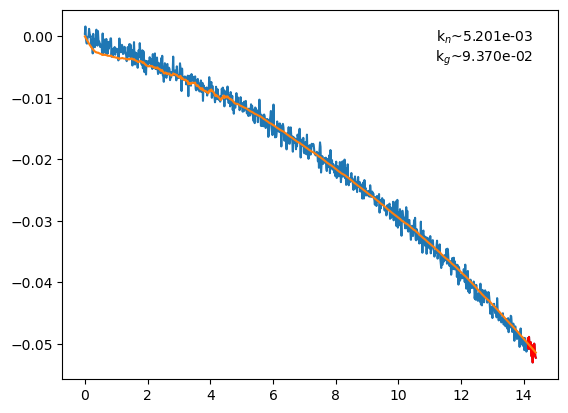

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.76it/s]


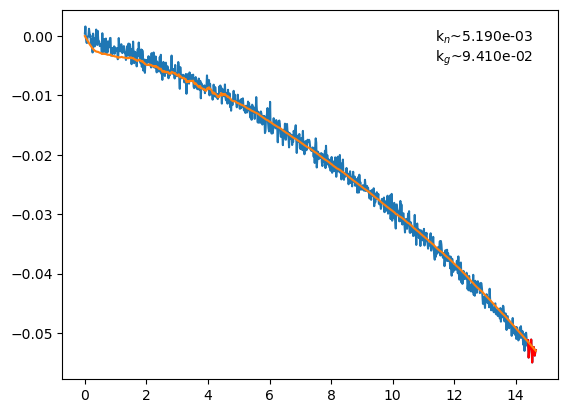

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.12it/s]


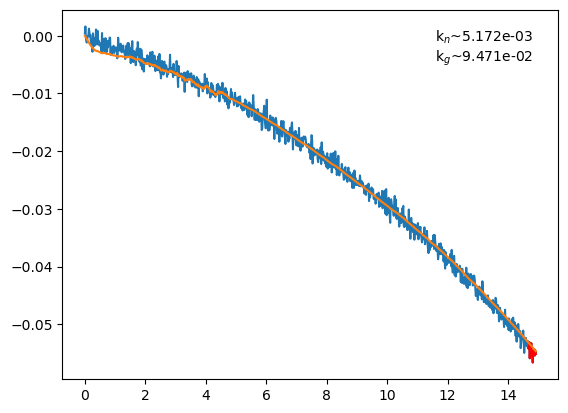

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.28it/s]


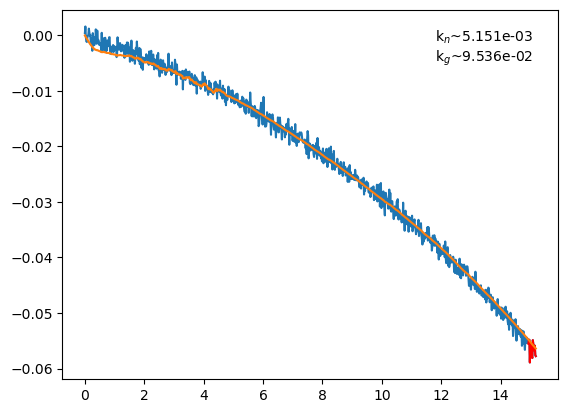

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.09it/s]


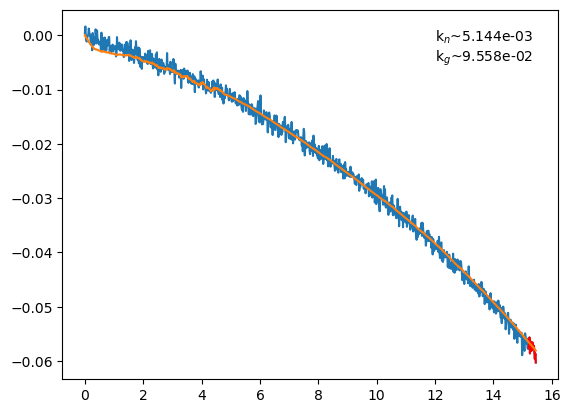

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.67it/s]


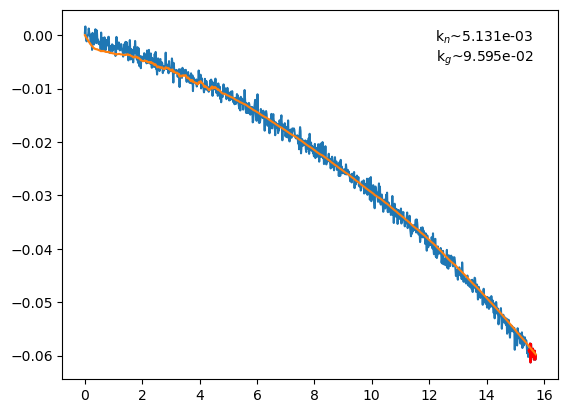

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 164.88it/s]


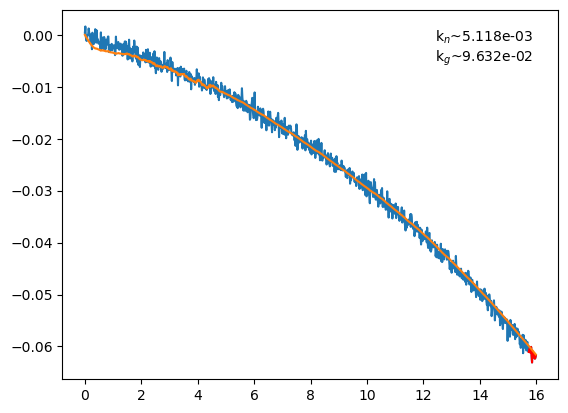

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.84it/s]


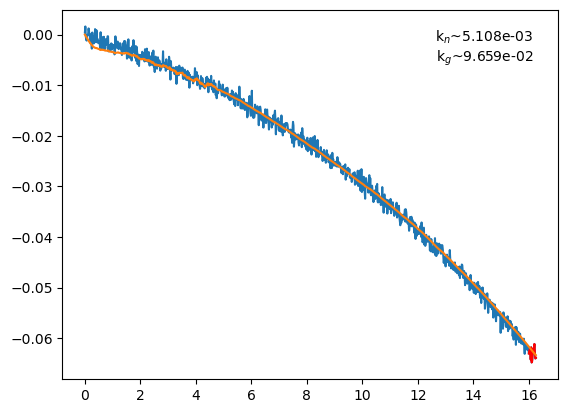

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.25it/s]


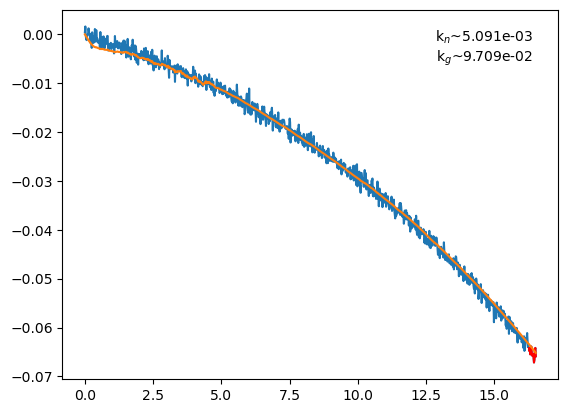

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.59it/s]


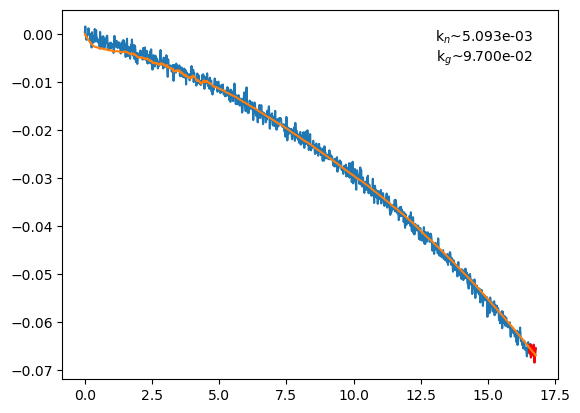

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.59it/s]


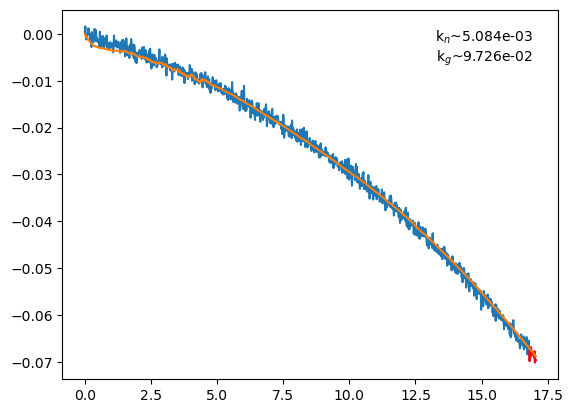

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.90it/s]


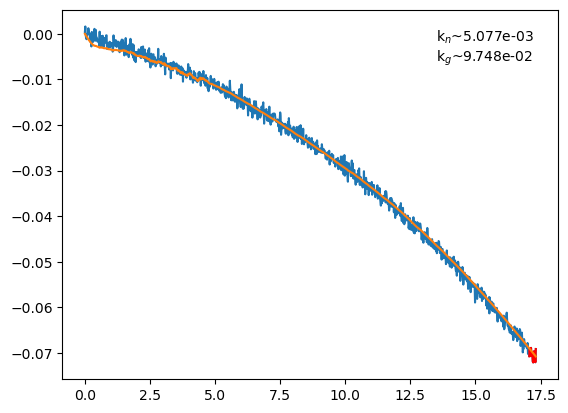

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.83it/s]


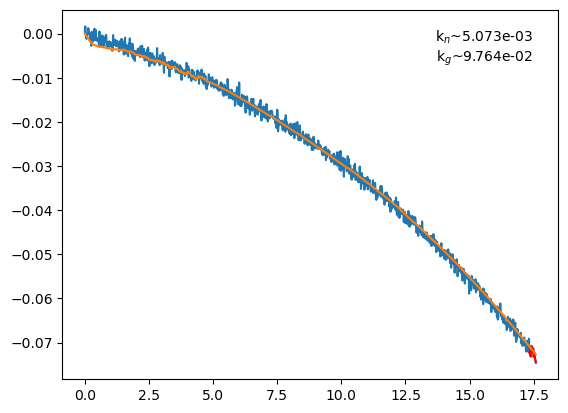

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 178.46it/s]


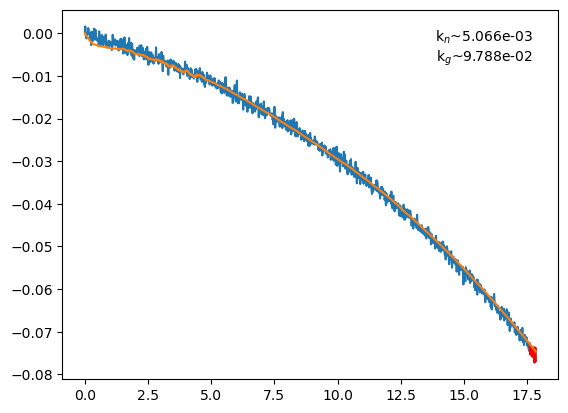

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.90it/s]


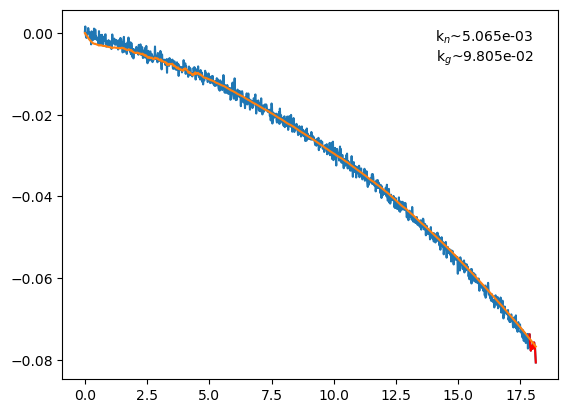

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.70it/s]


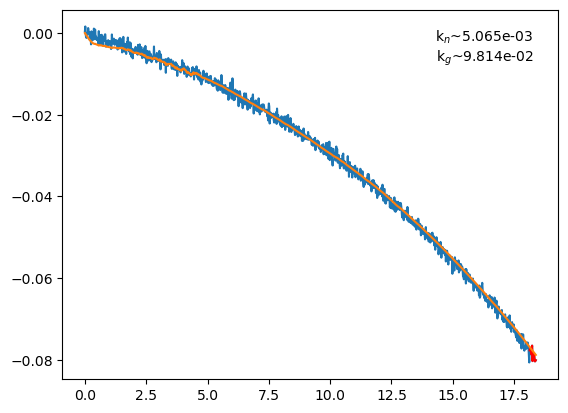

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.81it/s]


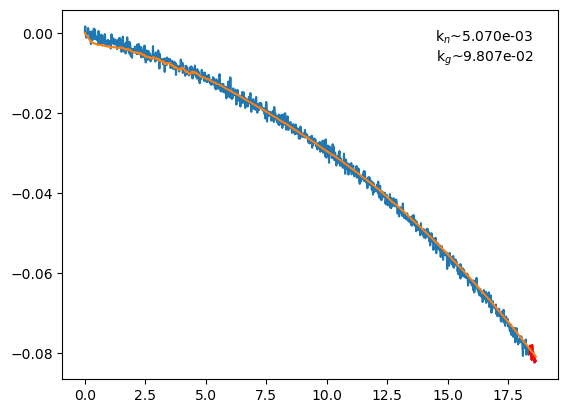

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.70it/s]


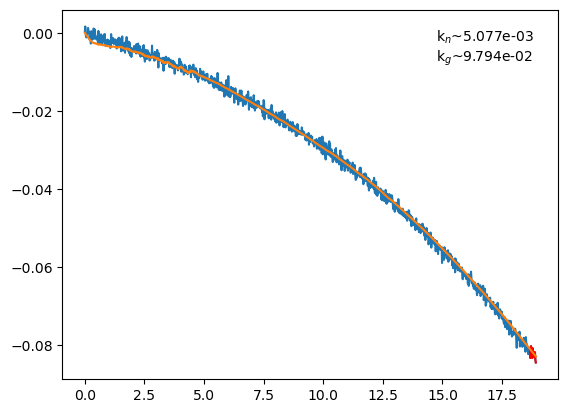

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.70it/s]


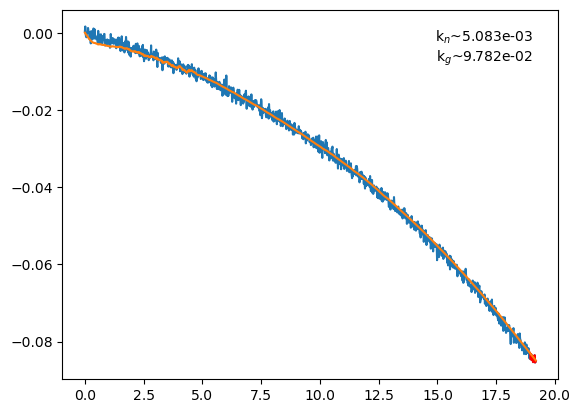

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 159.85it/s]


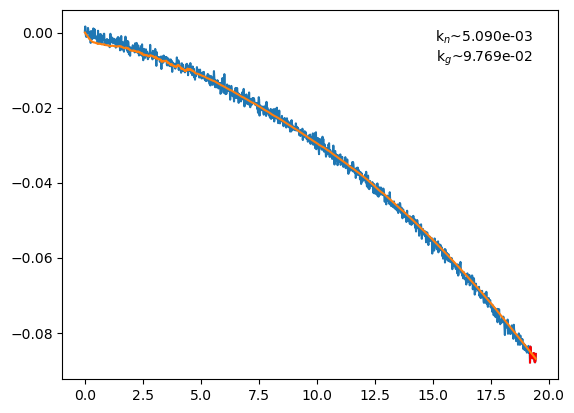

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.57it/s]


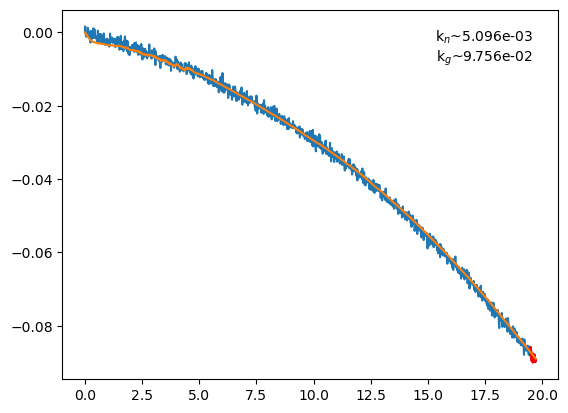

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.50it/s]


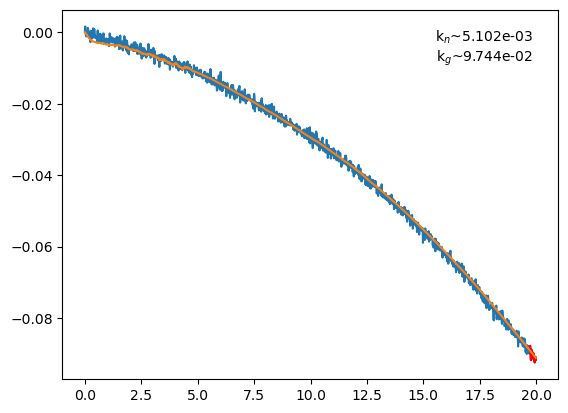

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.97it/s]


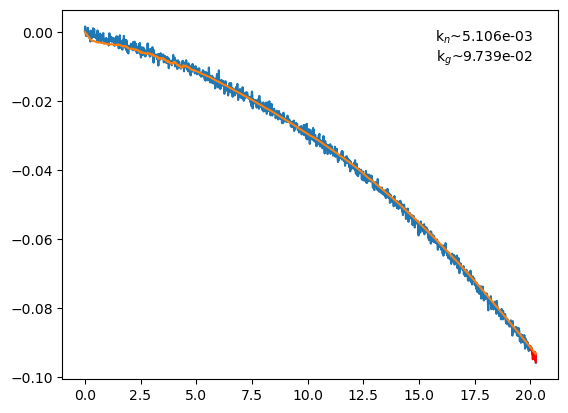

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.66it/s]


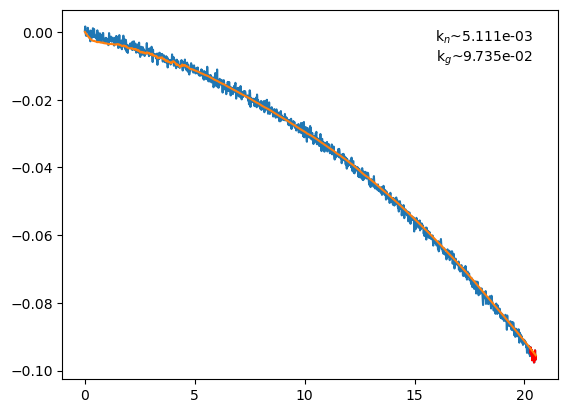

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.95it/s]


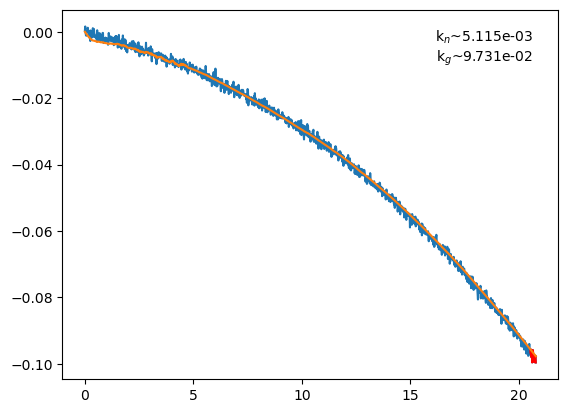

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.62it/s]


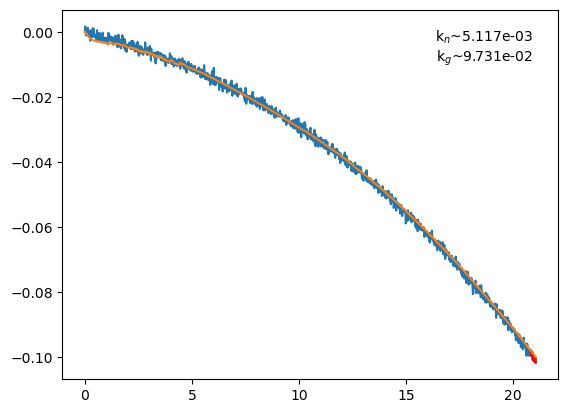

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 135.49it/s]


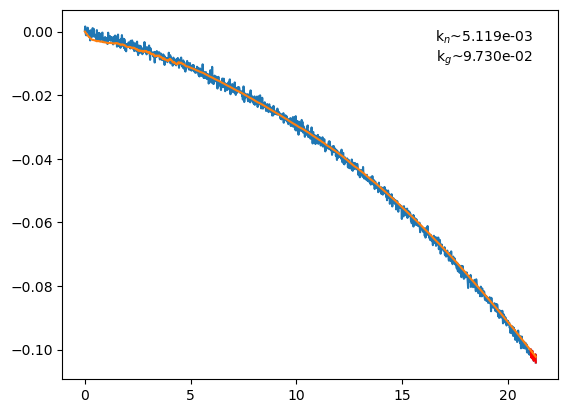

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 164.86it/s]


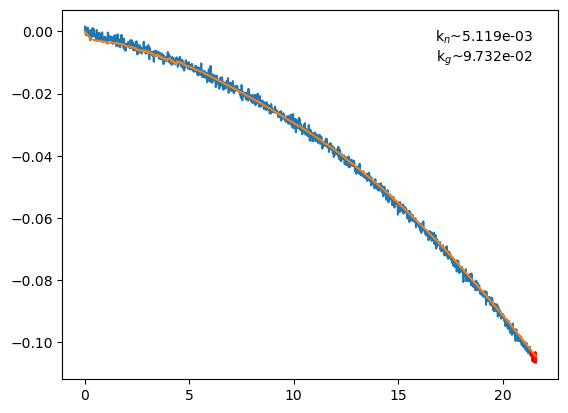

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.97it/s]


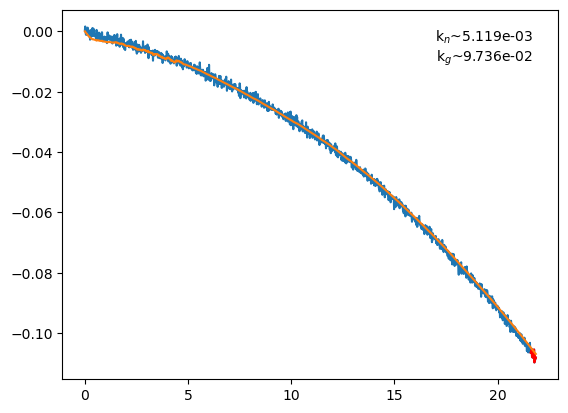

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.68it/s]


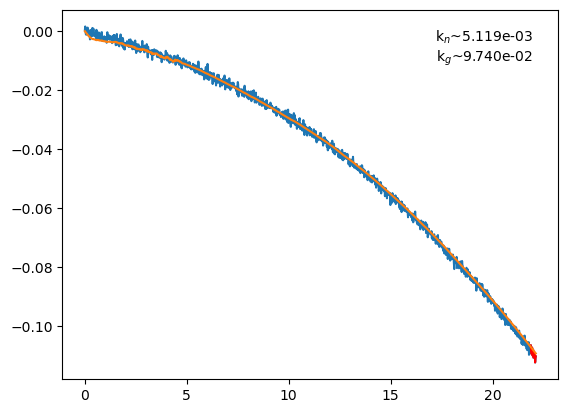

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.68it/s]


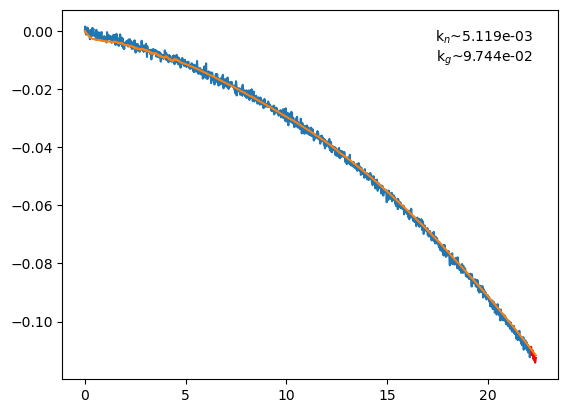

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.64it/s]


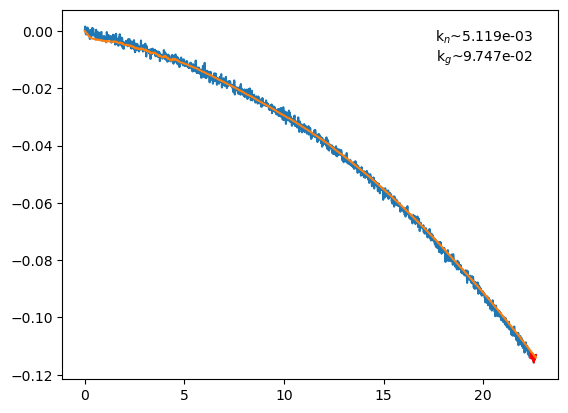

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.81it/s]


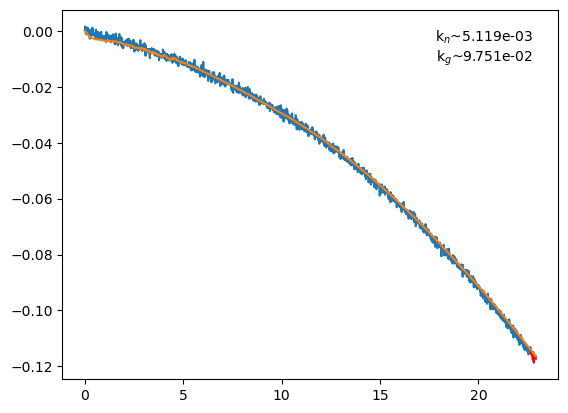

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.74it/s]


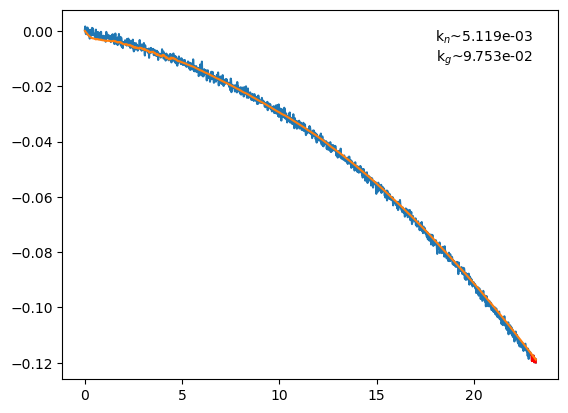

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.72it/s]


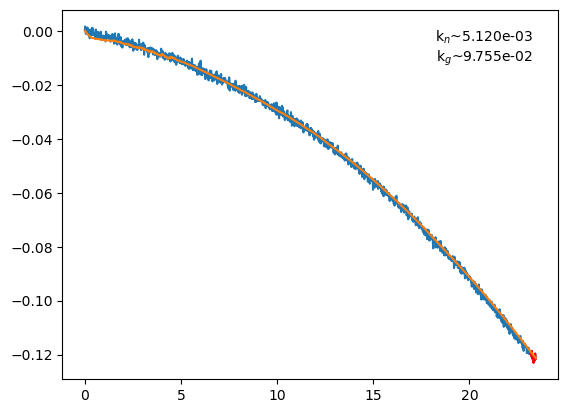

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.65it/s]


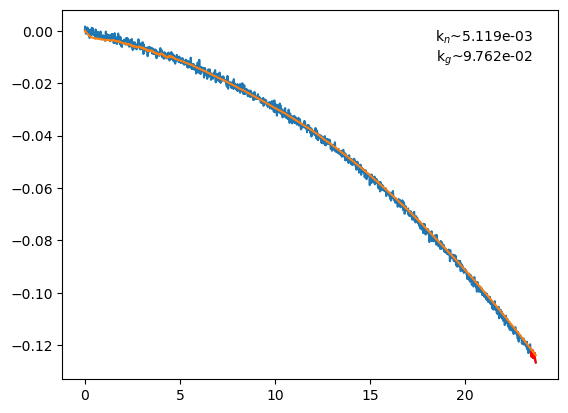

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.51it/s]


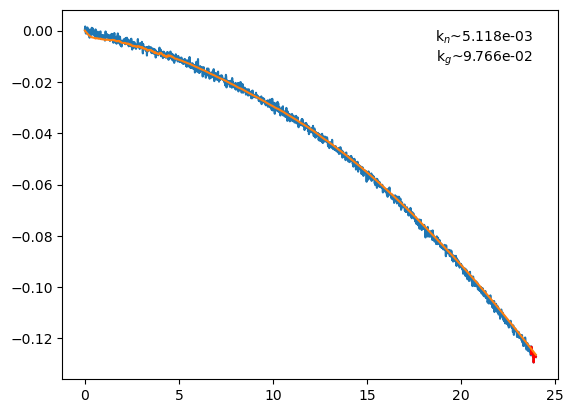

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.00it/s]


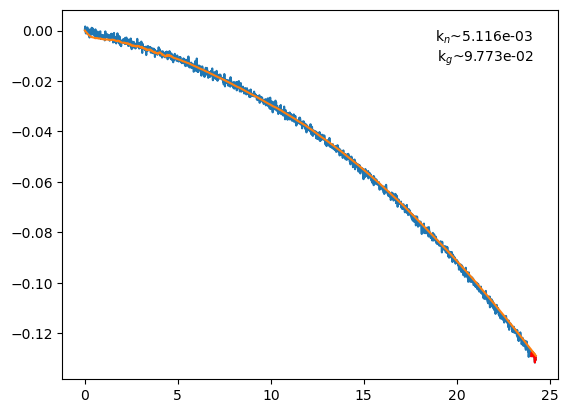

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.82it/s]


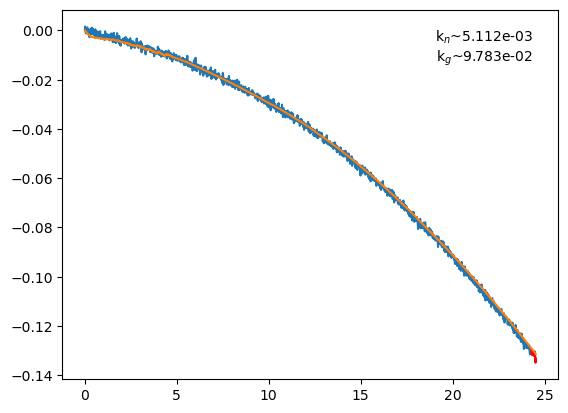

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.54it/s]


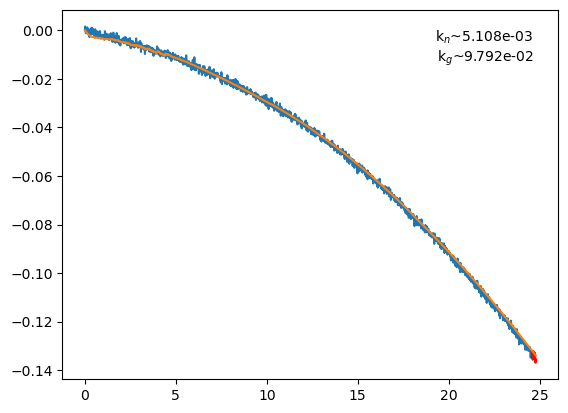

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.79it/s]


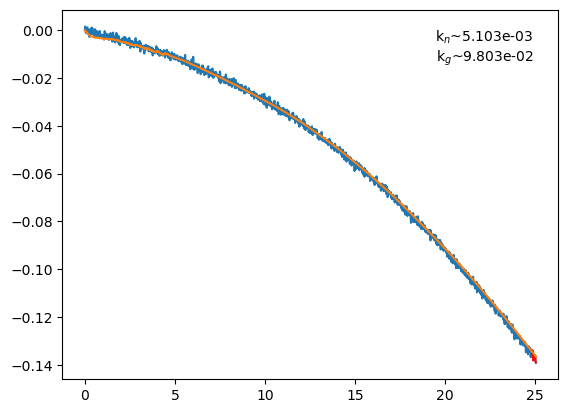

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.05it/s]


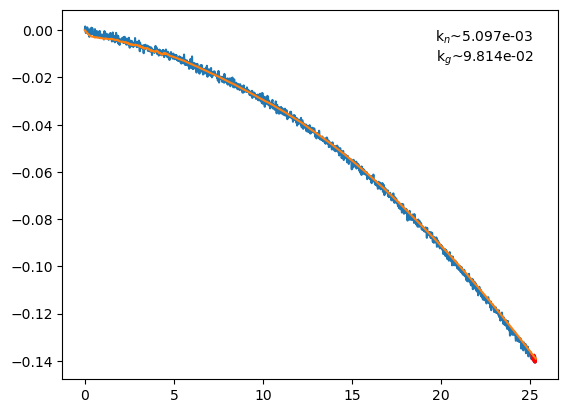

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.73it/s]


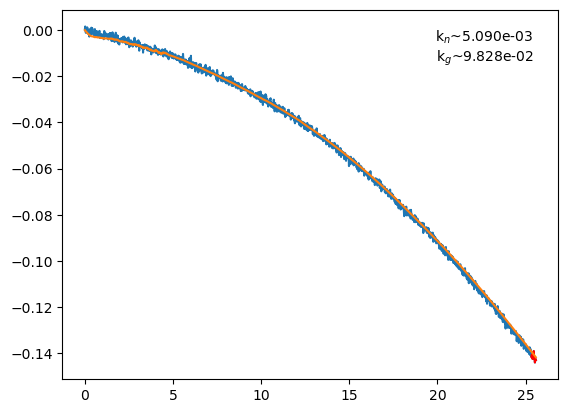

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.63it/s]


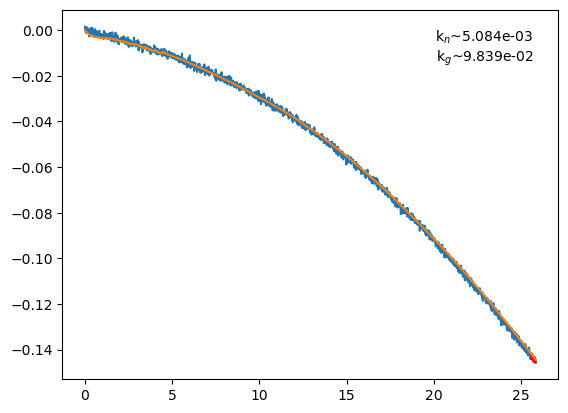

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.74it/s]


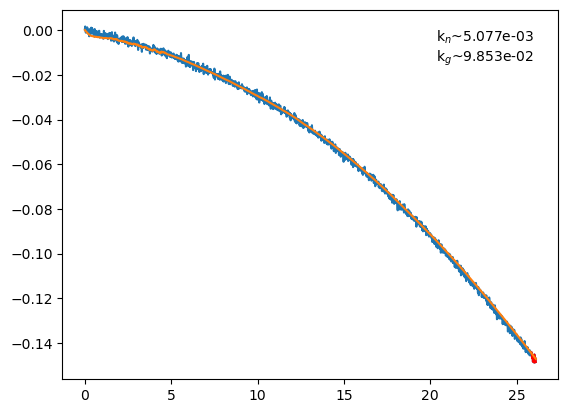

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 174.27it/s]


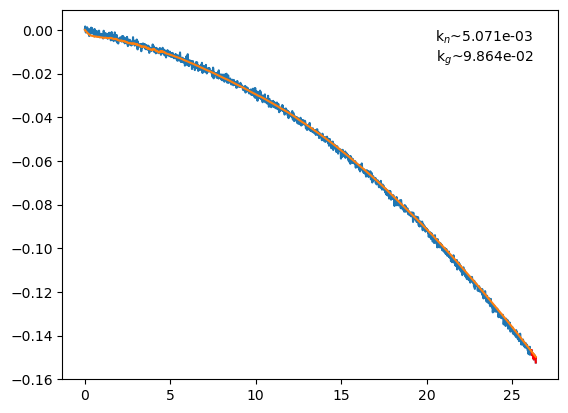

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.78it/s]


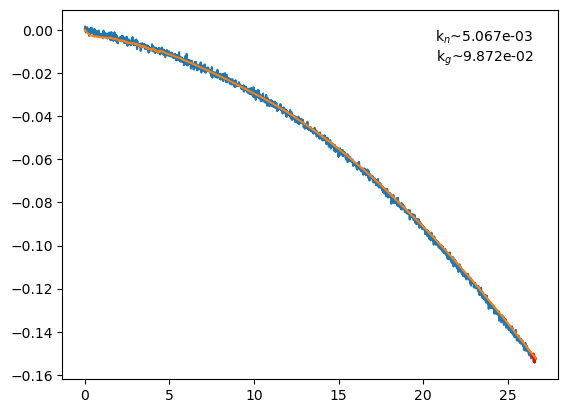

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.83it/s]


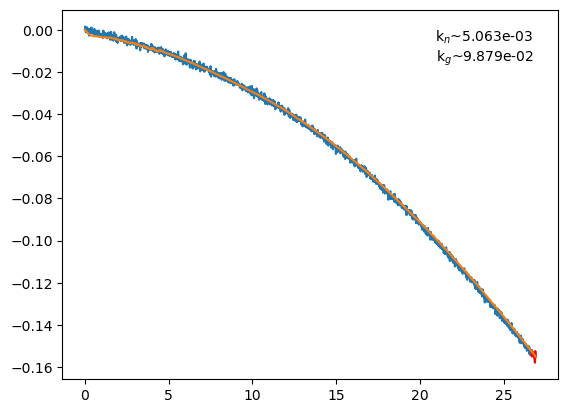

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.00it/s]


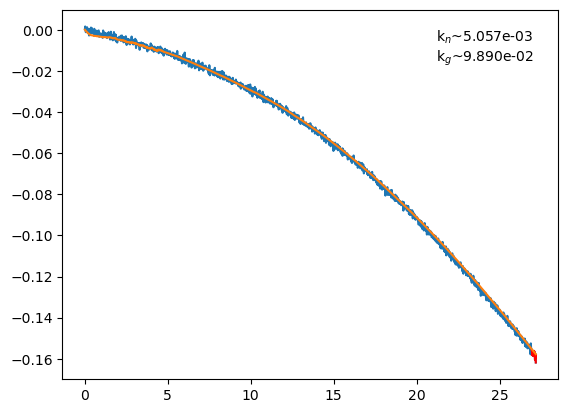

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.32it/s]


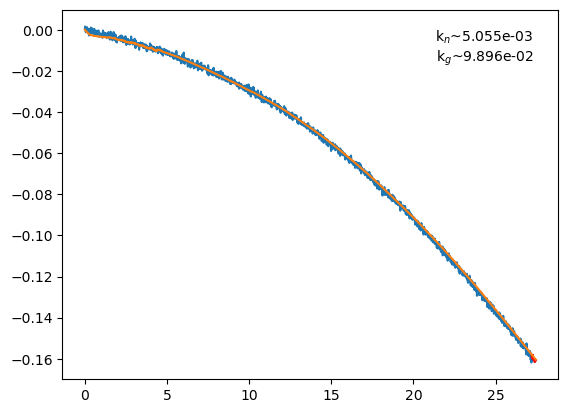

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.95it/s]


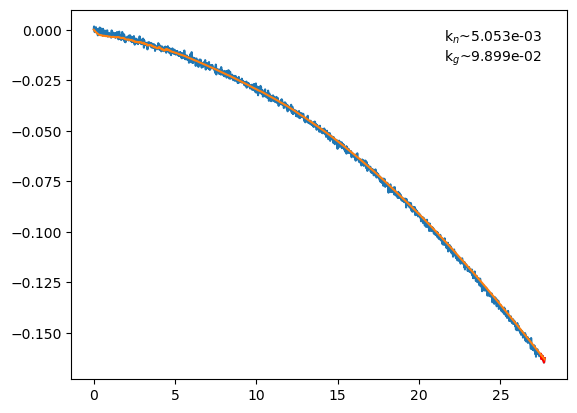

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.81it/s]


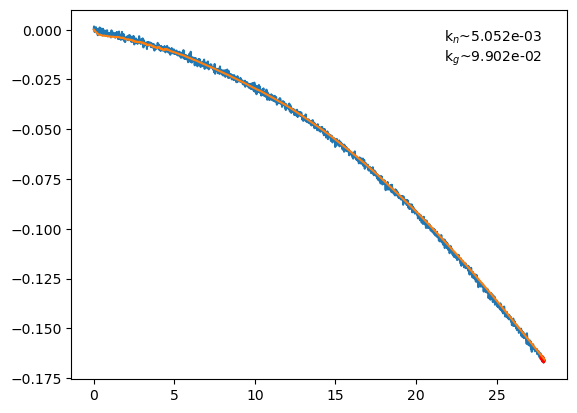

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.95it/s]


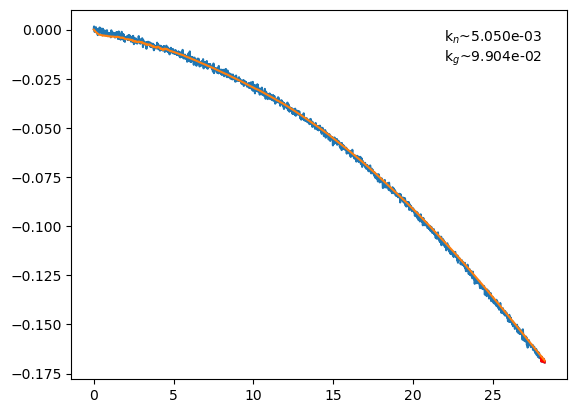

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.95it/s]


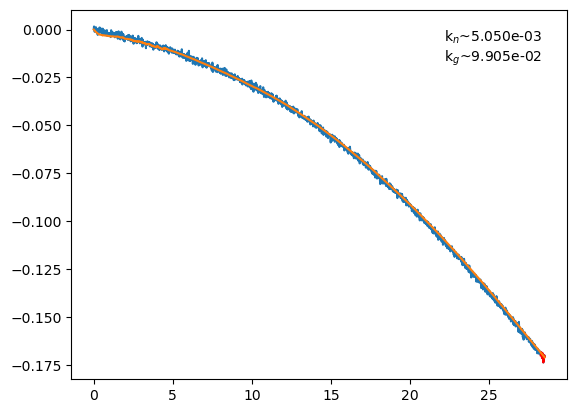

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.31it/s]


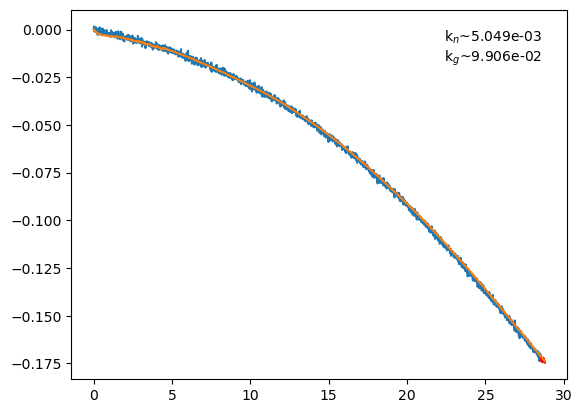

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.97it/s]


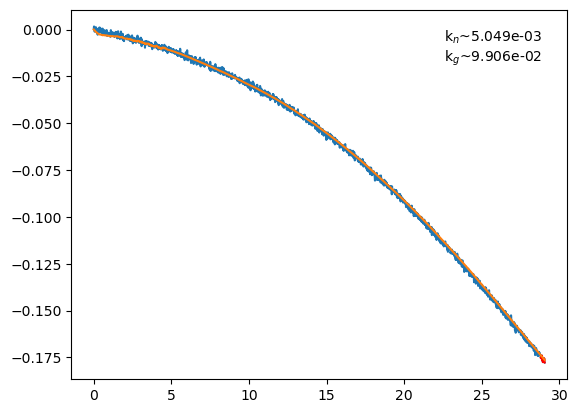

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.19it/s]


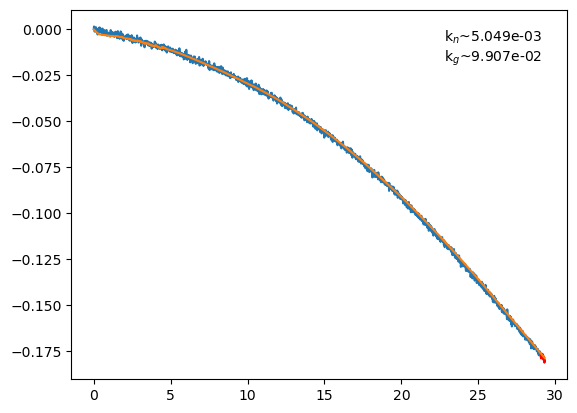

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.89it/s]


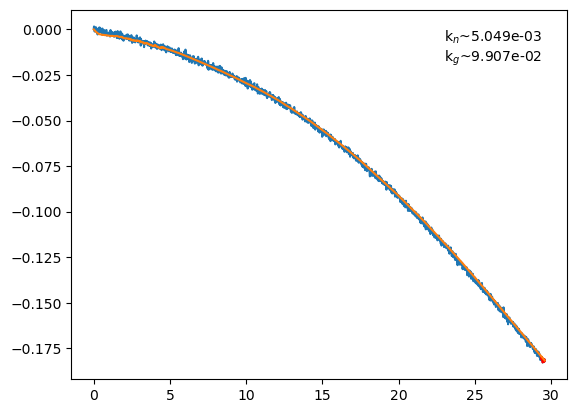

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.82it/s]


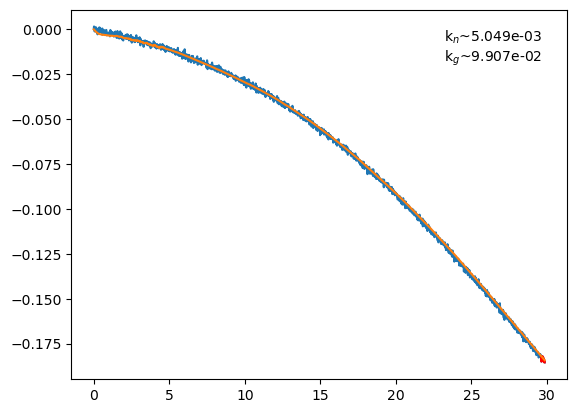

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.79it/s]


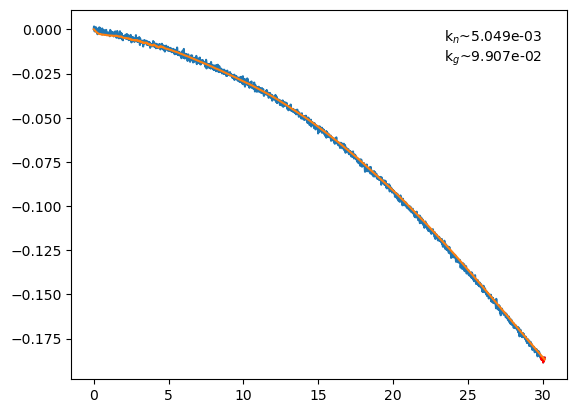

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.79it/s]


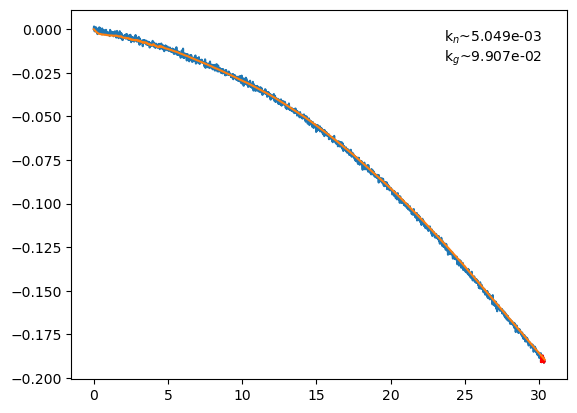

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.02it/s]


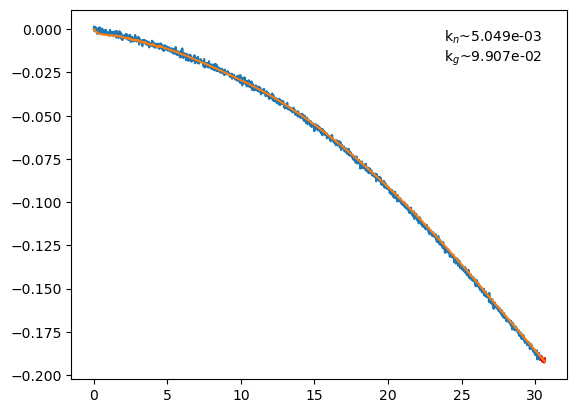

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.24it/s]


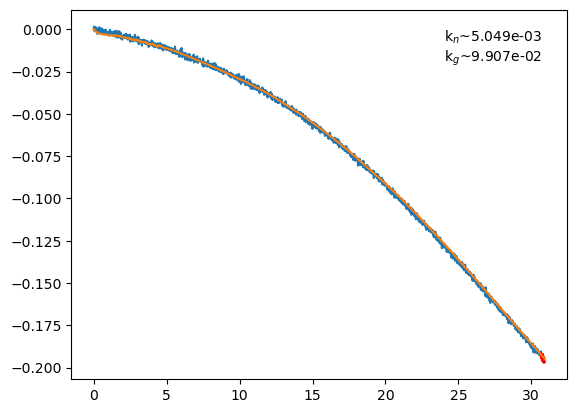

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.98it/s]


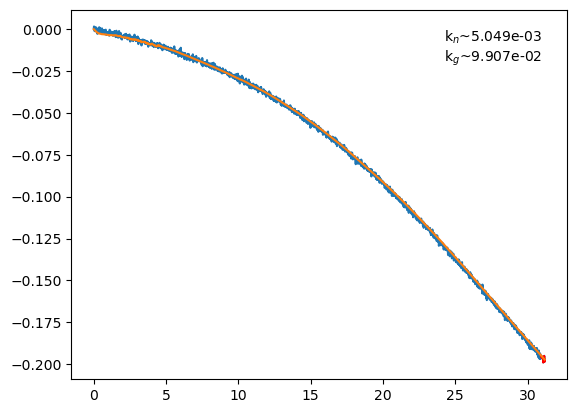

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 159.83it/s]


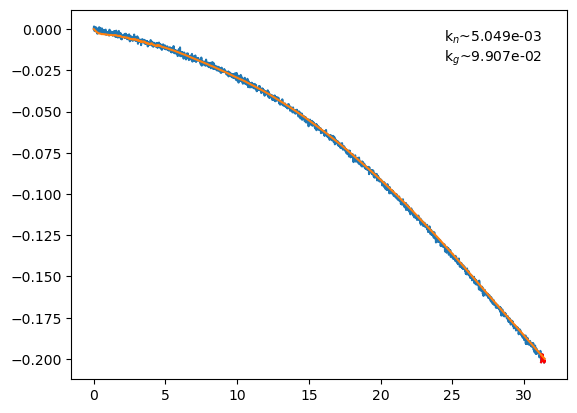

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.80it/s]


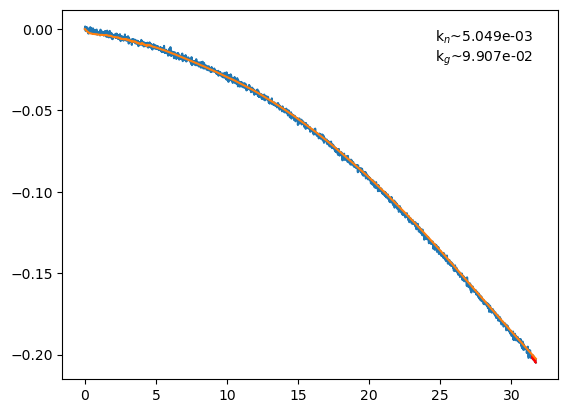

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.83it/s]


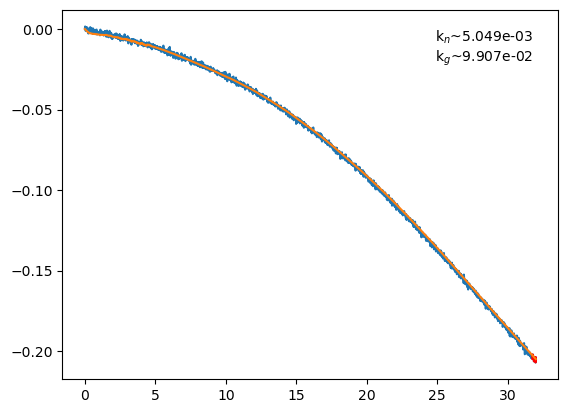

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.06it/s]


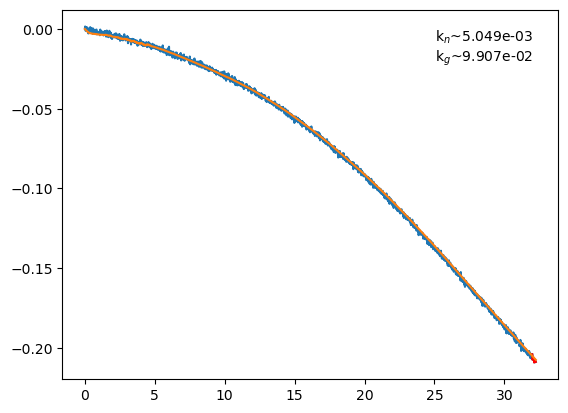

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.96it/s]


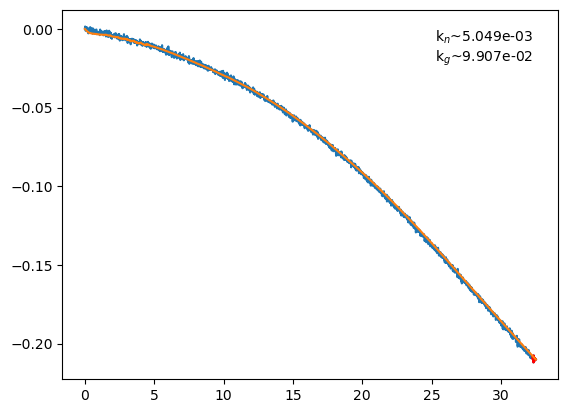

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.75it/s]


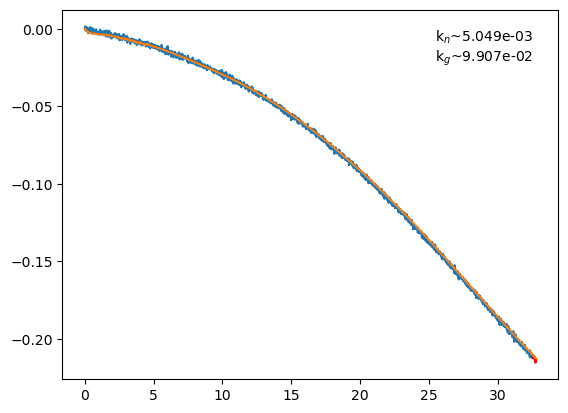

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 154.41it/s]


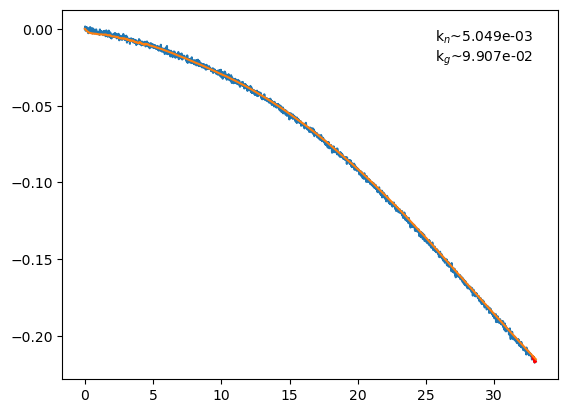

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 158.39it/s]


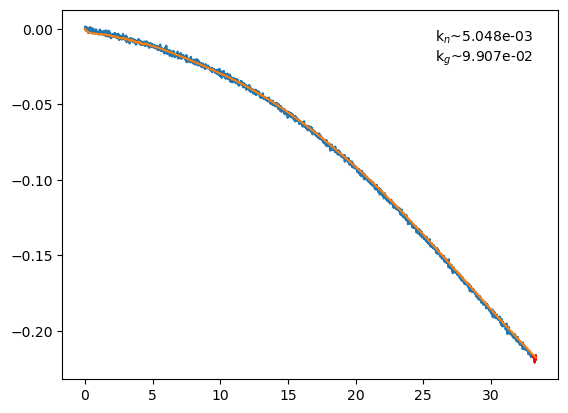

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.21it/s]


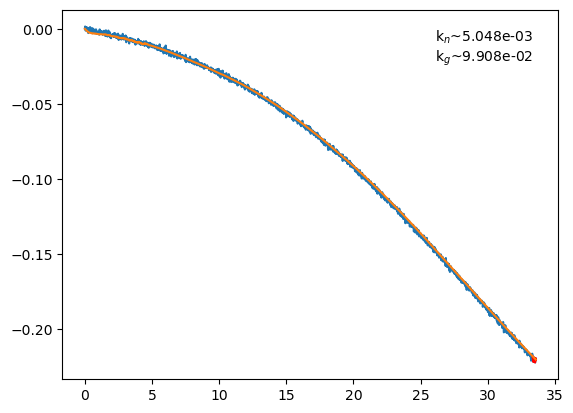

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.35it/s]


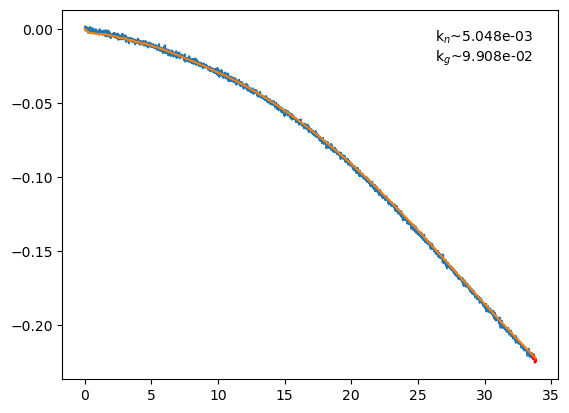

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.20it/s]


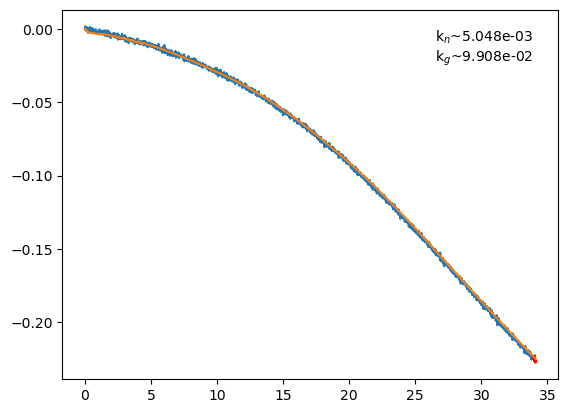

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.37it/s]


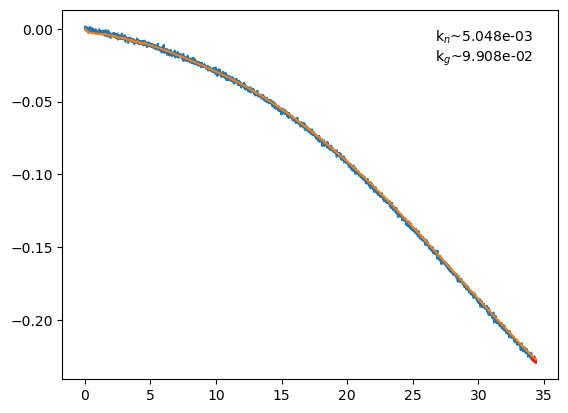

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.15it/s]


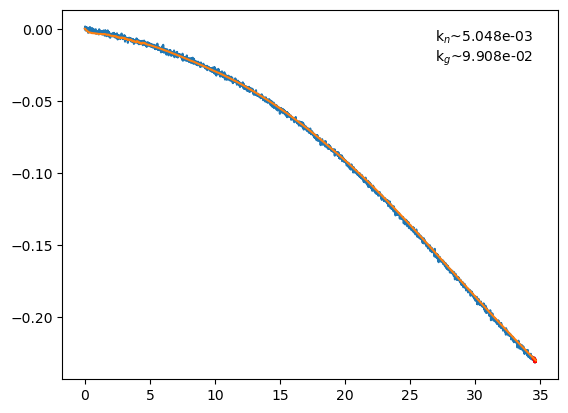

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.83it/s]


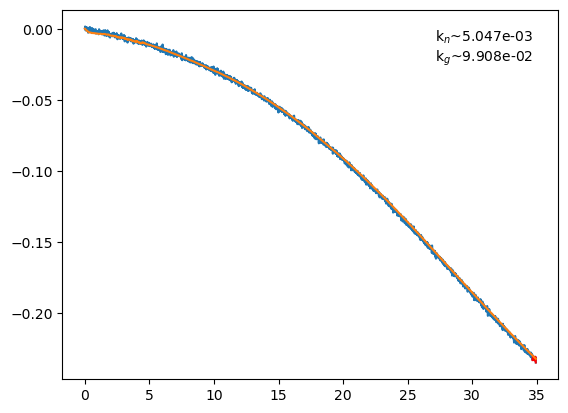

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.79it/s]


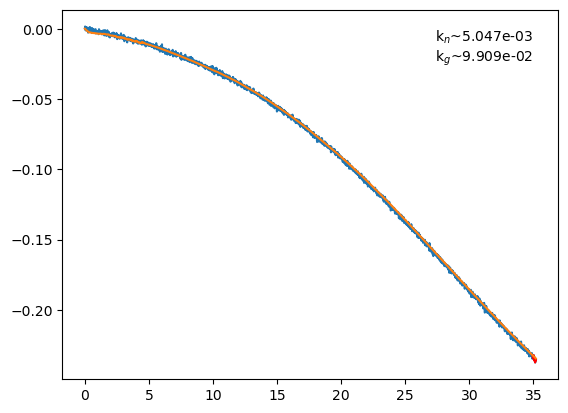

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.71it/s]


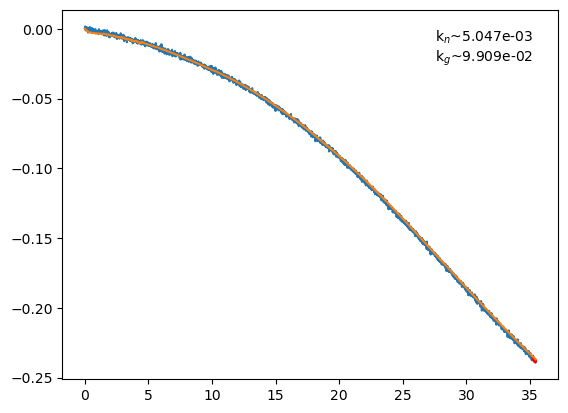

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.56it/s]


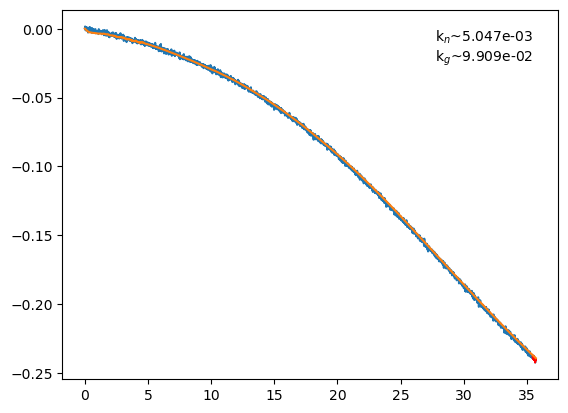

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.55it/s]


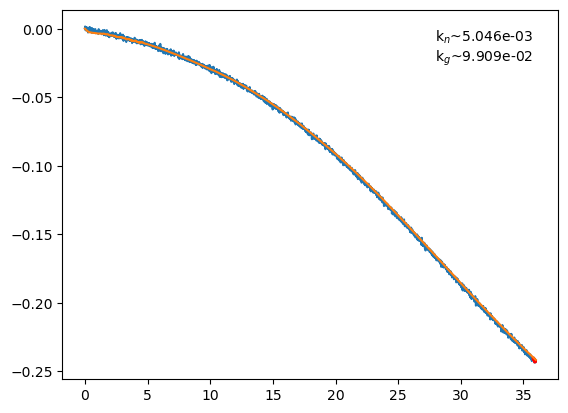

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 164.79it/s]


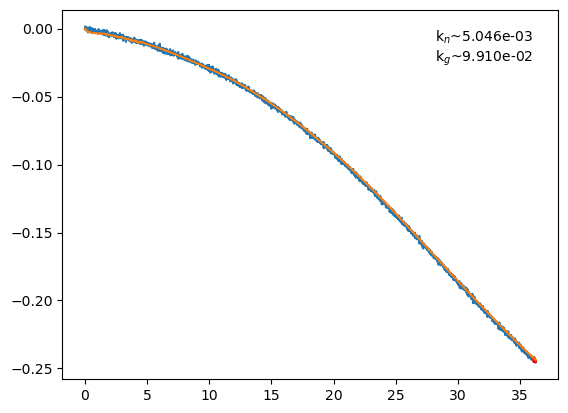

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.36it/s]


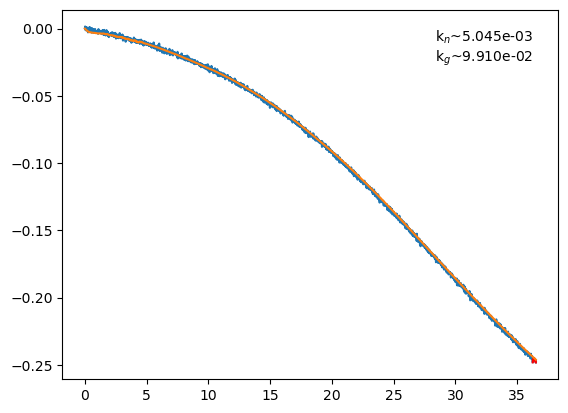

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.59it/s]


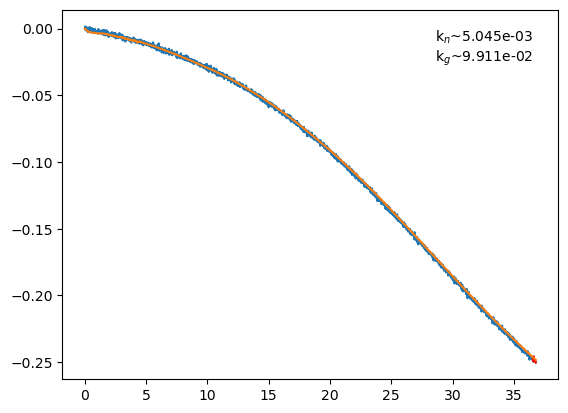

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.27it/s]


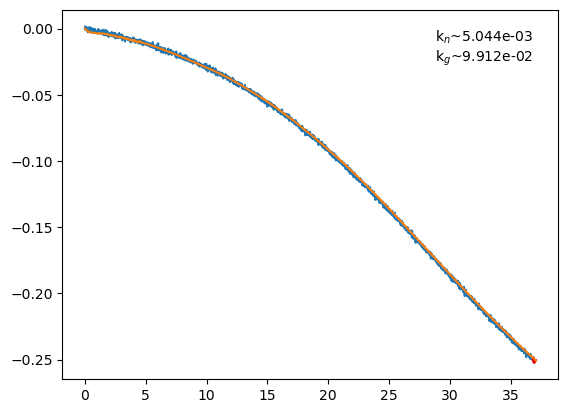

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.80it/s]


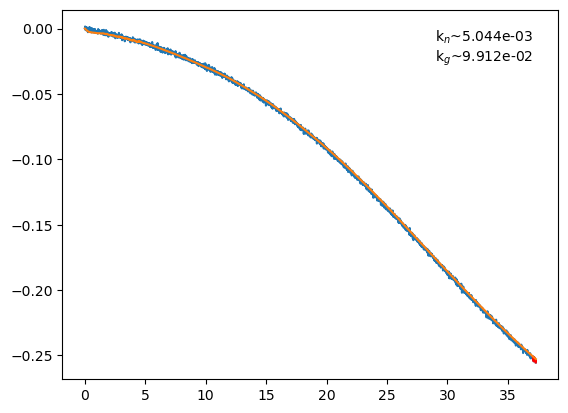

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.42it/s]


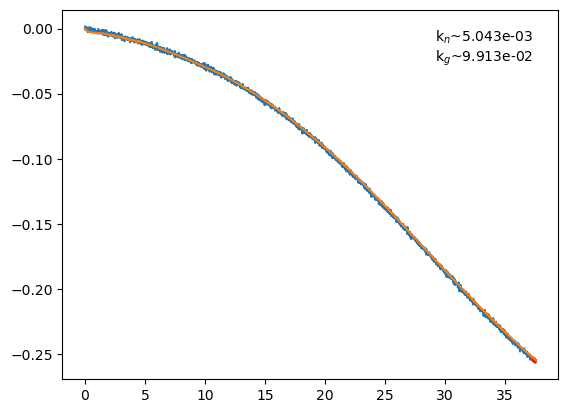

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.42it/s]


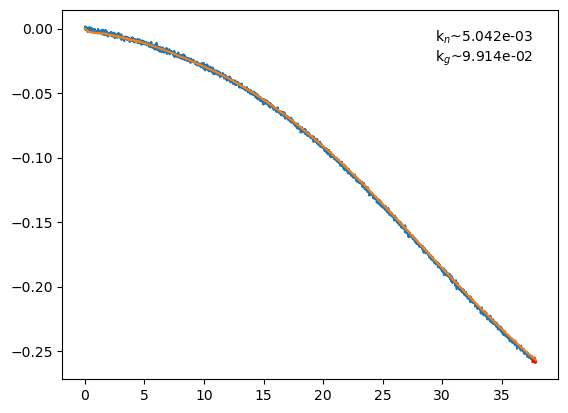

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.79it/s]


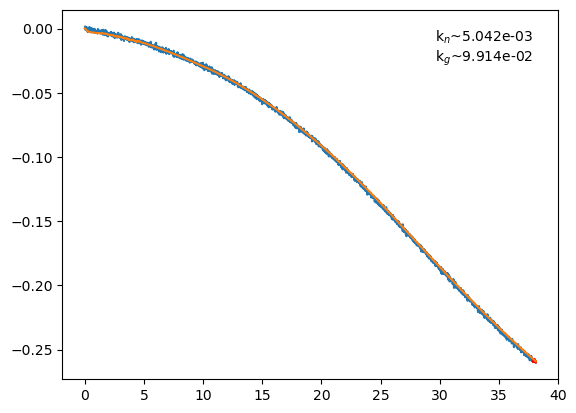

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.04it/s]


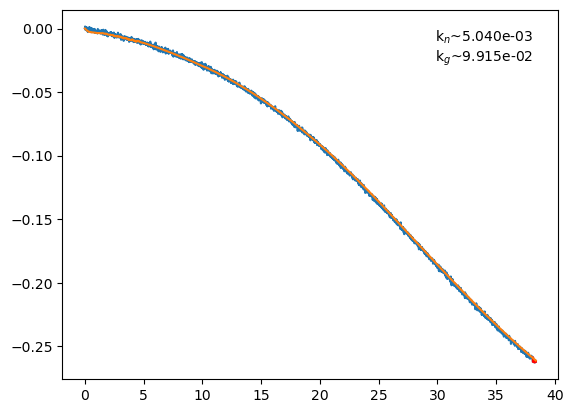

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.04it/s]


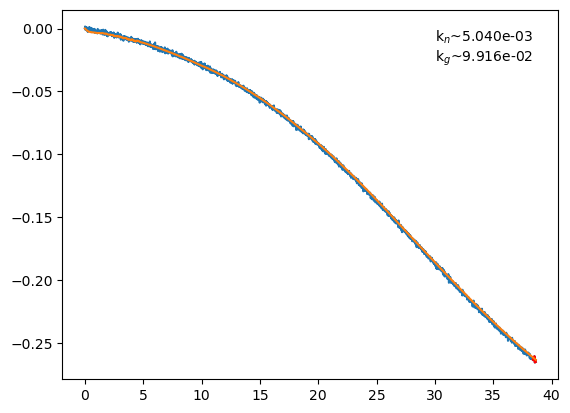

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 139.01it/s]


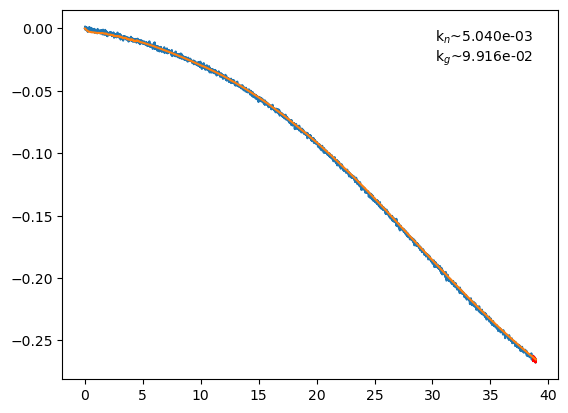

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.67it/s]


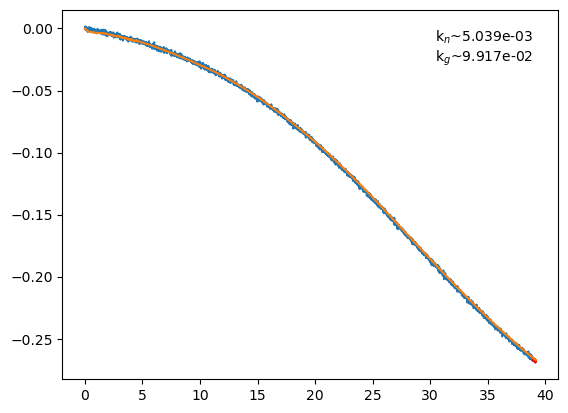

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.63it/s]


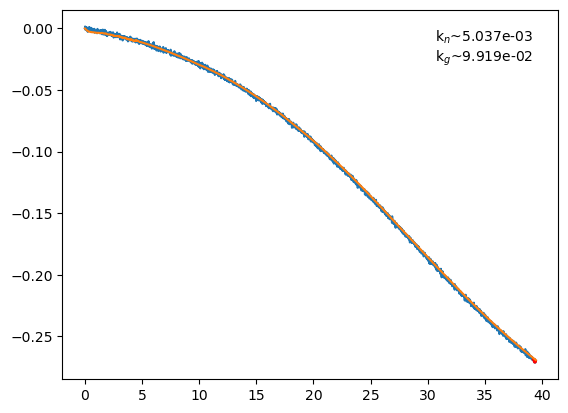

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 164.87it/s]


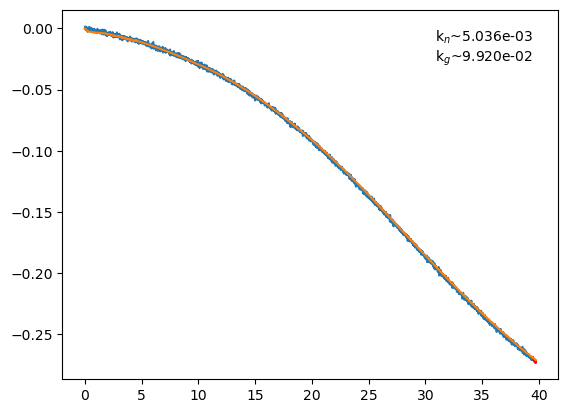

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.34it/s]


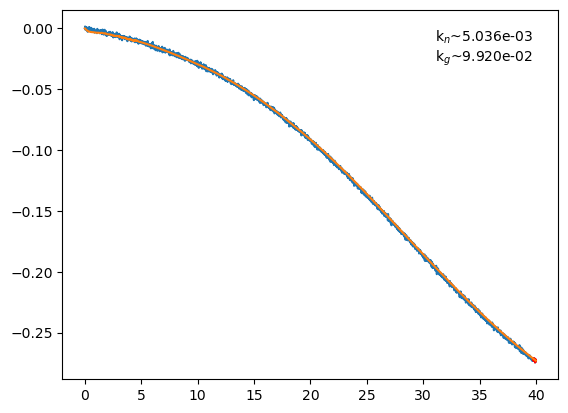

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.43it/s]


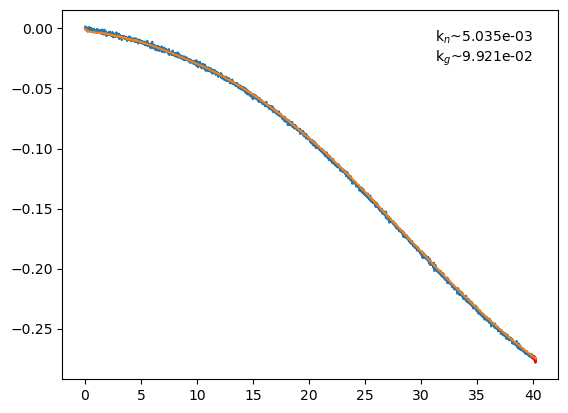

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 161.67it/s]


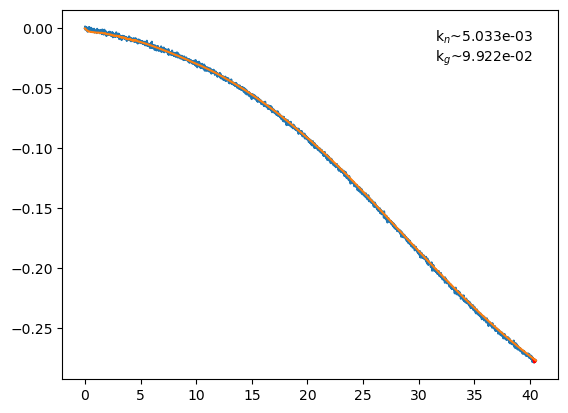

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.74it/s]


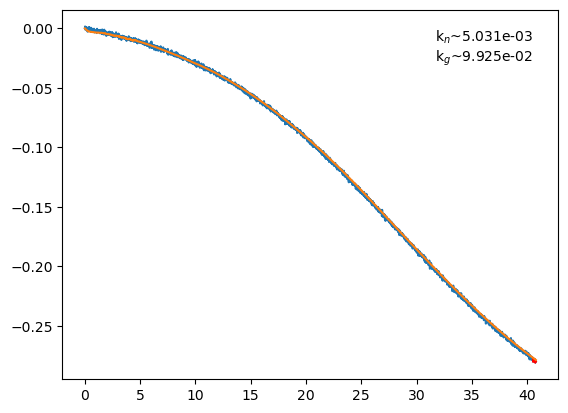

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.06it/s]


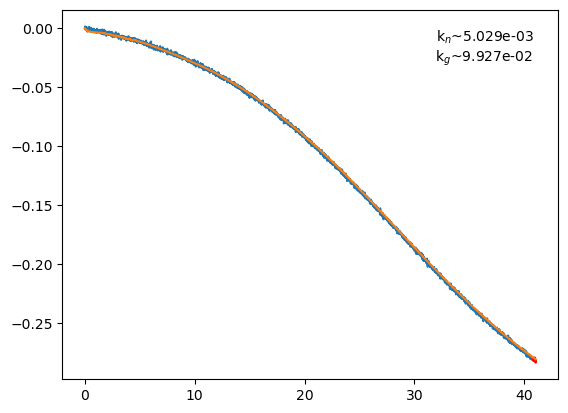

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.72it/s]


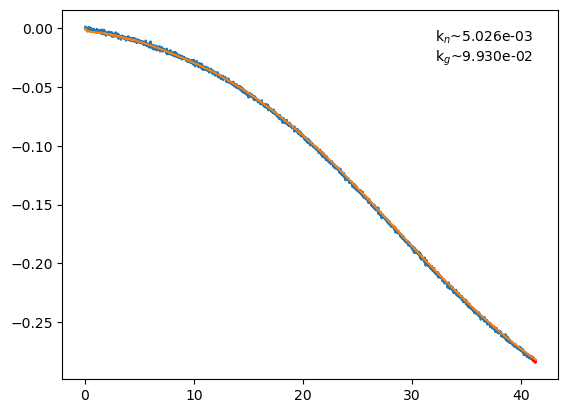

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 178.60it/s]


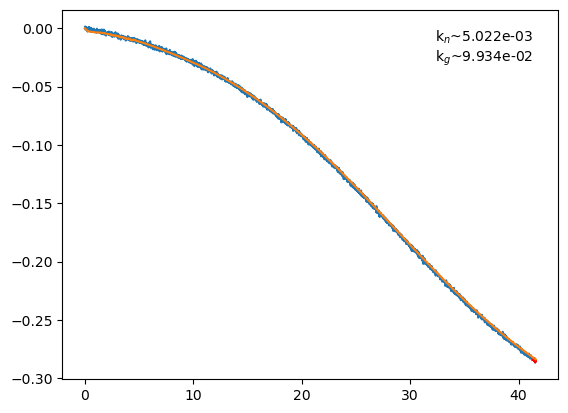

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.31it/s]


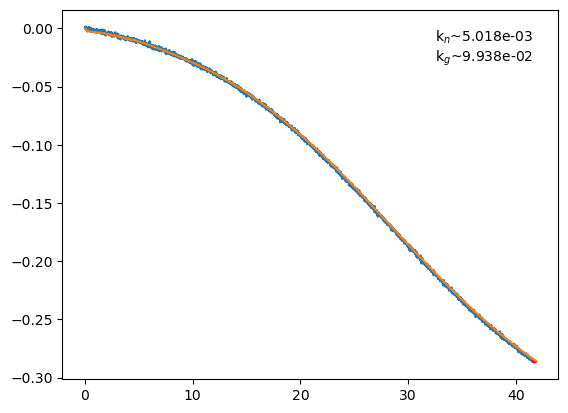

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.37it/s]


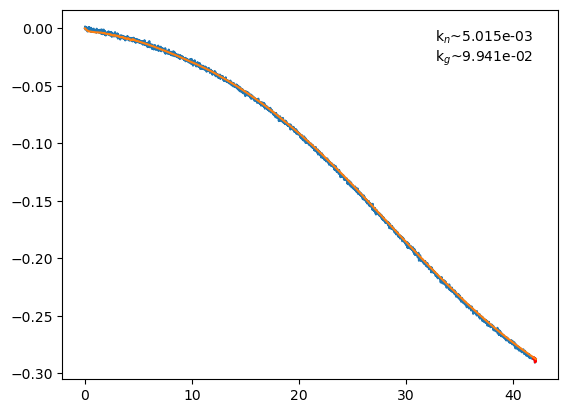

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 169.32it/s]


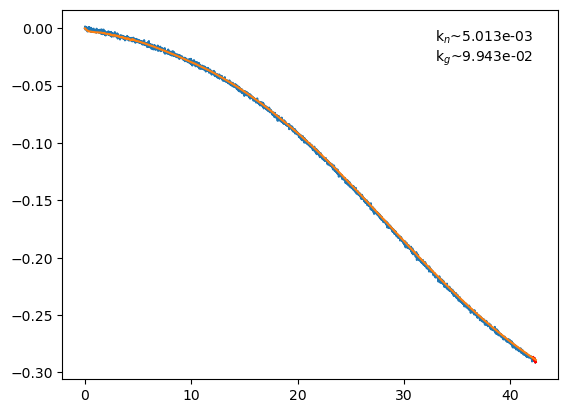

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.58it/s]


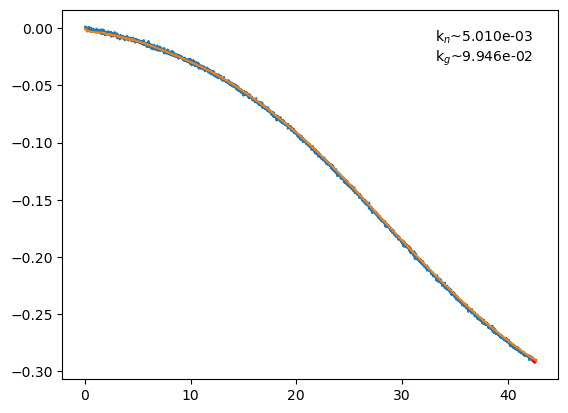

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.03it/s]


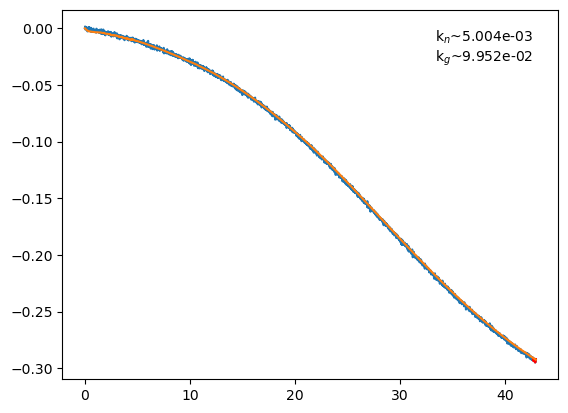

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.57it/s]


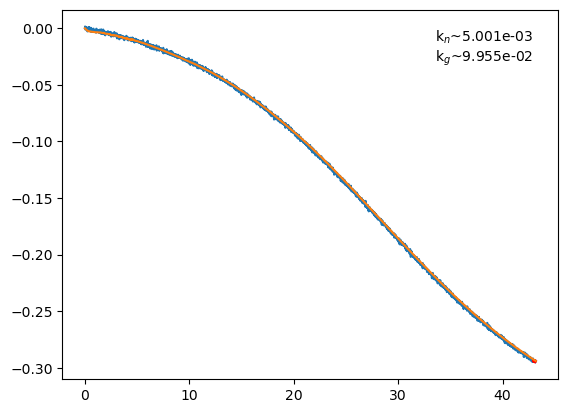

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 164.82it/s]


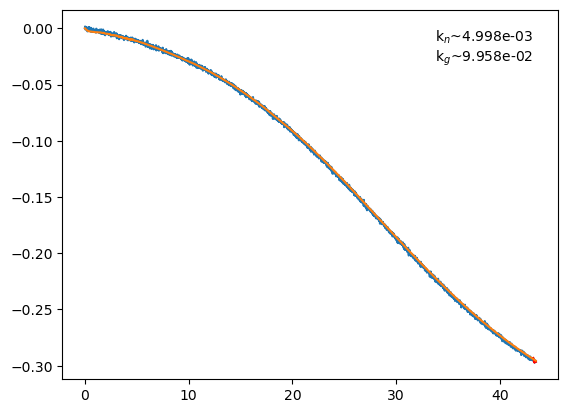

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 165.47it/s]


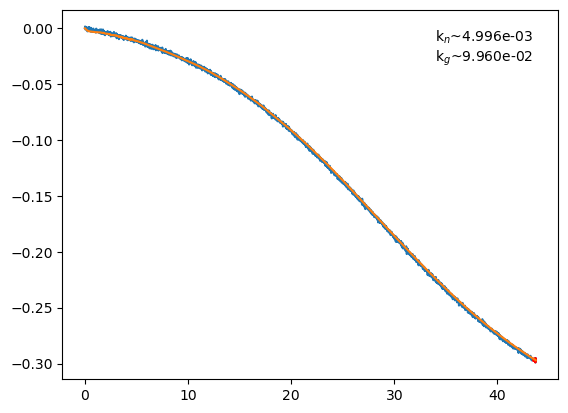

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.73it/s]


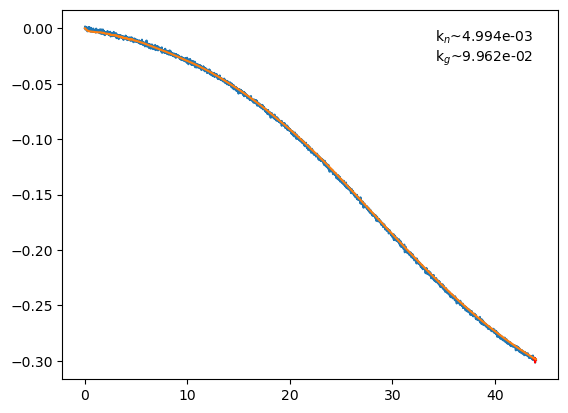

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.61it/s]


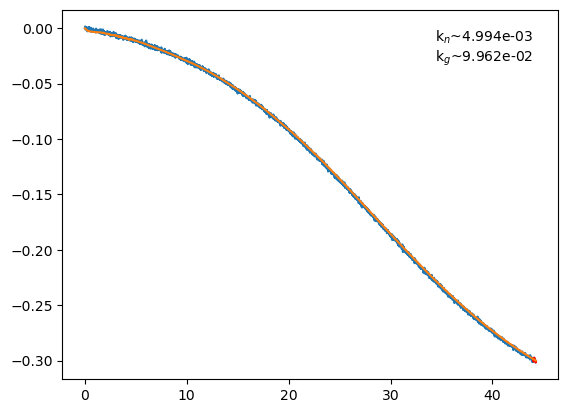

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 174.00it/s]


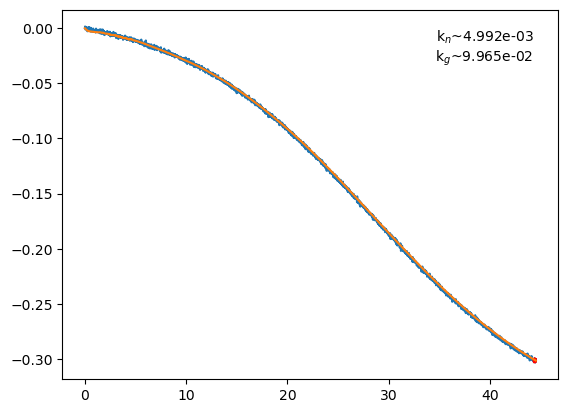

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.86it/s]


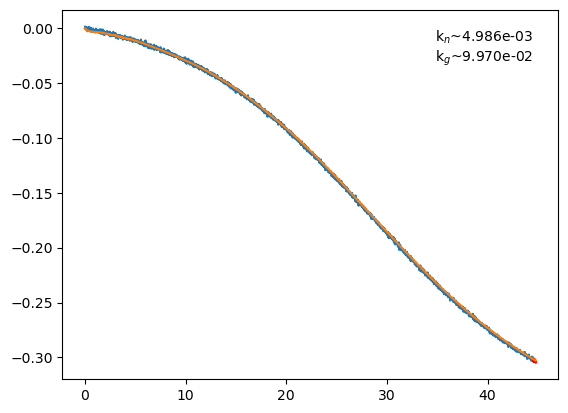

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.75it/s]


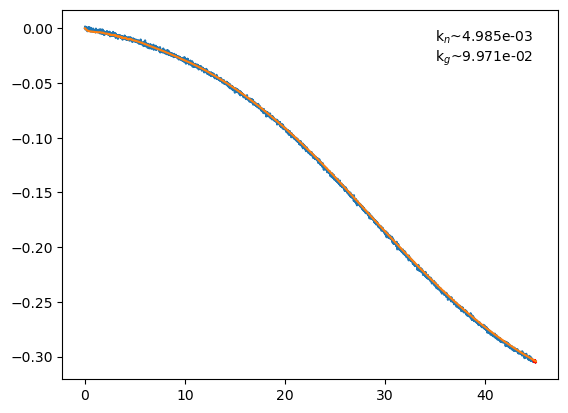

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.09it/s]


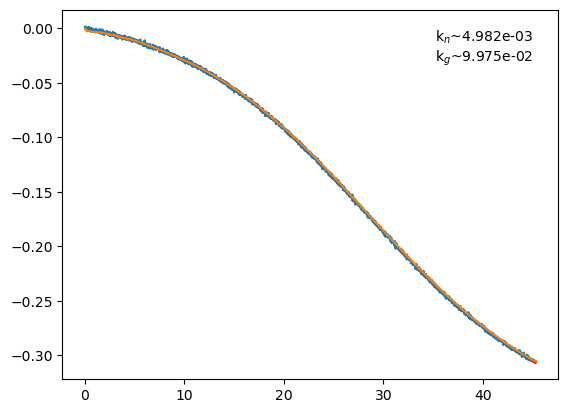

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.87it/s]


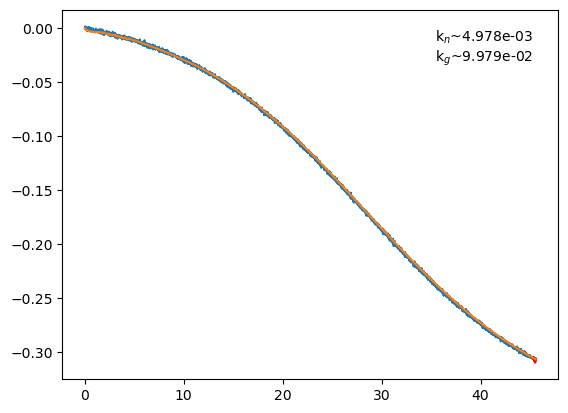

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 174.28it/s]


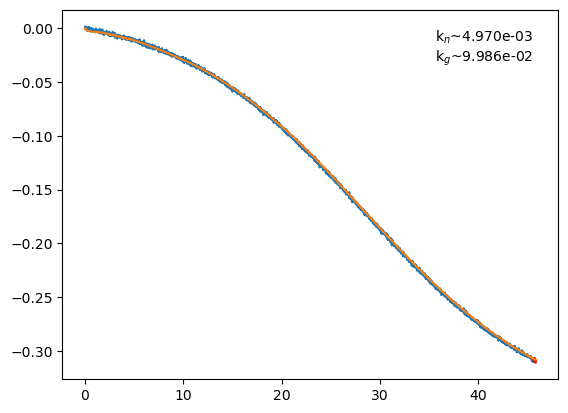

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.12it/s]


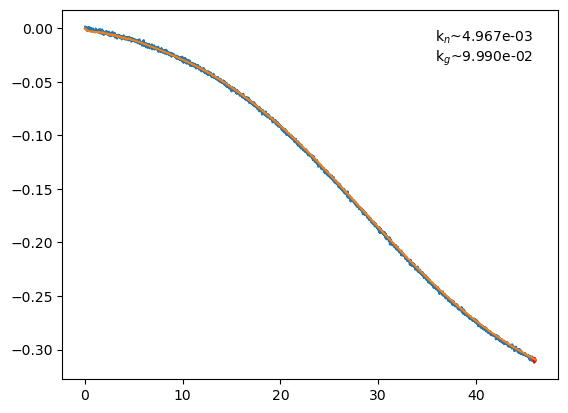

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 131.12it/s]


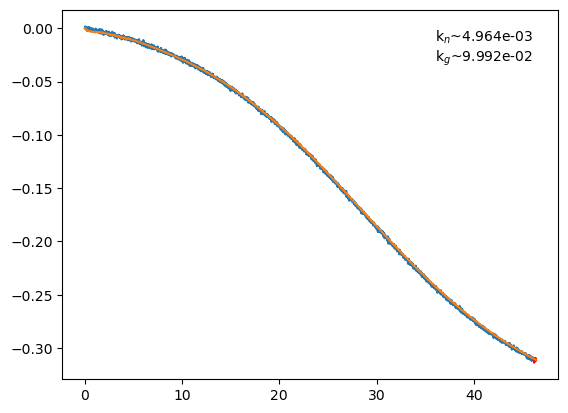

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.72it/s]


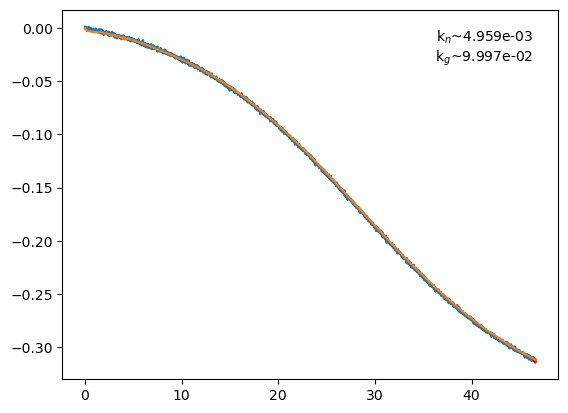

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.04it/s]


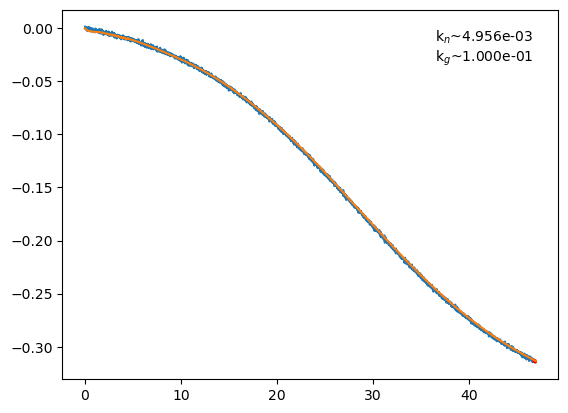

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.07it/s]


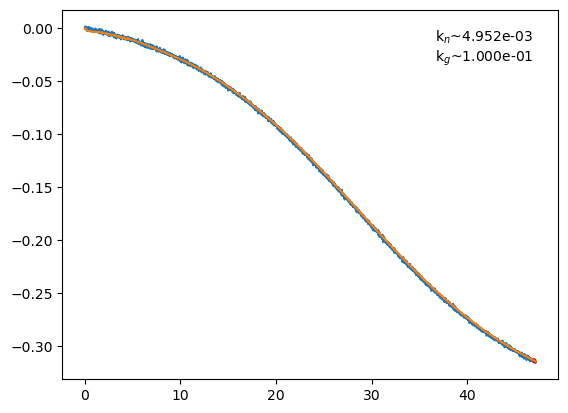

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.11it/s]


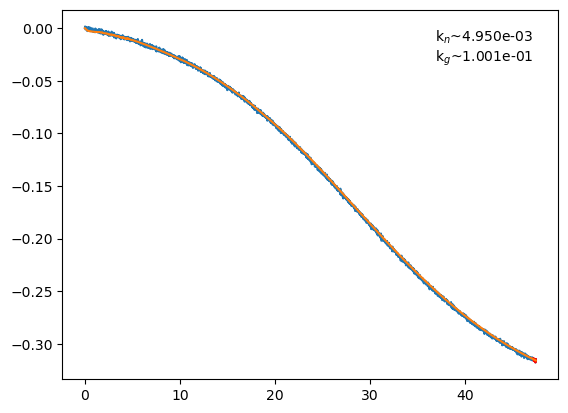

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.13it/s]


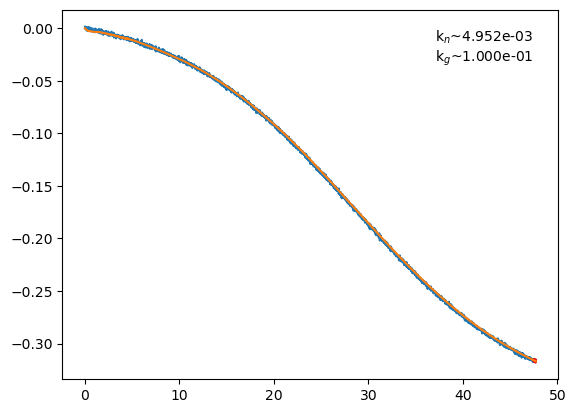

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 176.88it/s]


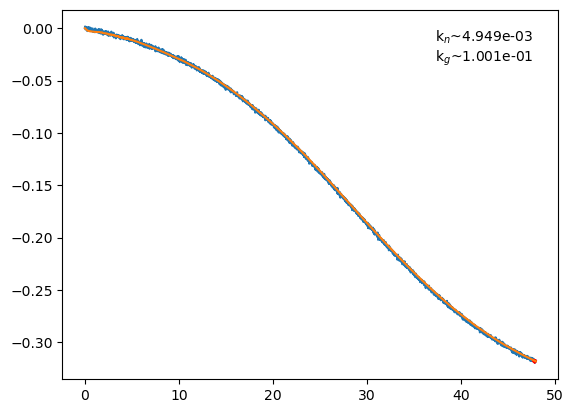

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.10it/s]


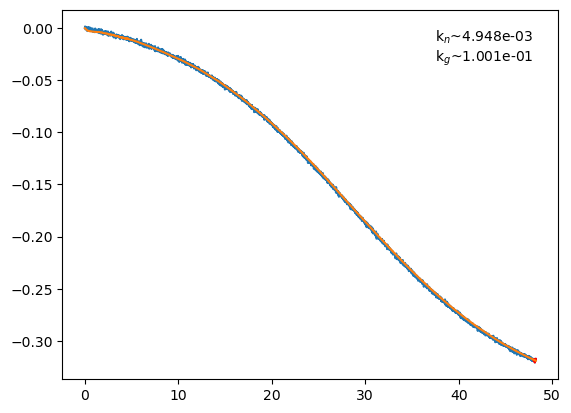

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.27it/s]


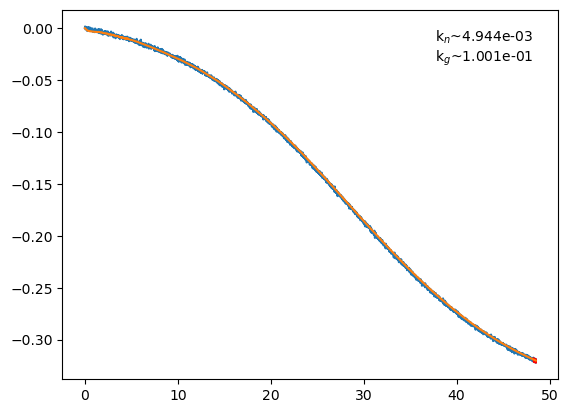

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.85it/s]


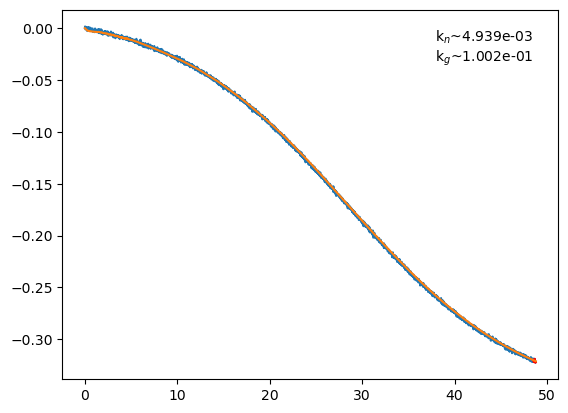

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.46it/s]


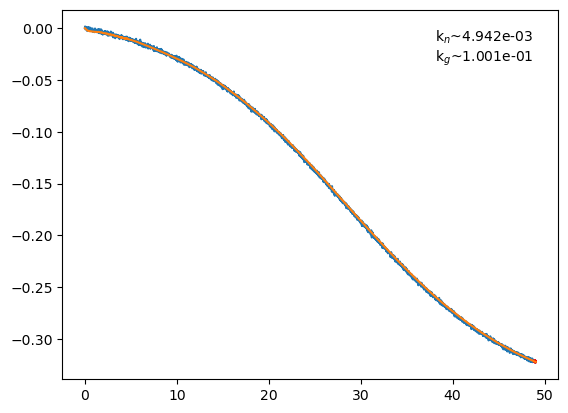

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.14it/s]


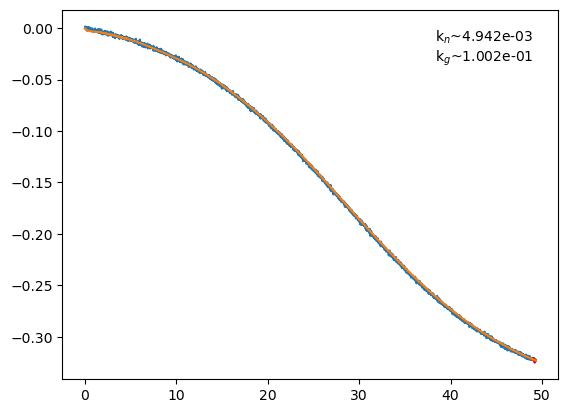

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.81it/s]


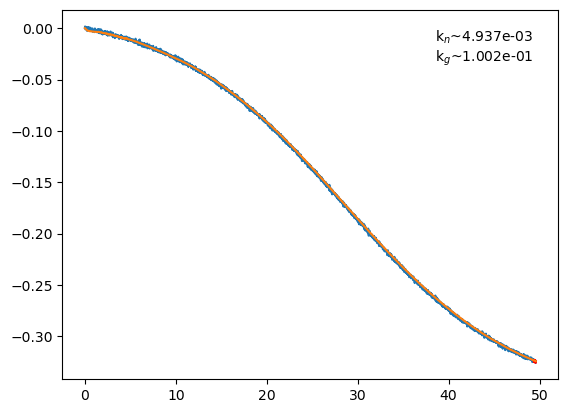

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.50it/s]


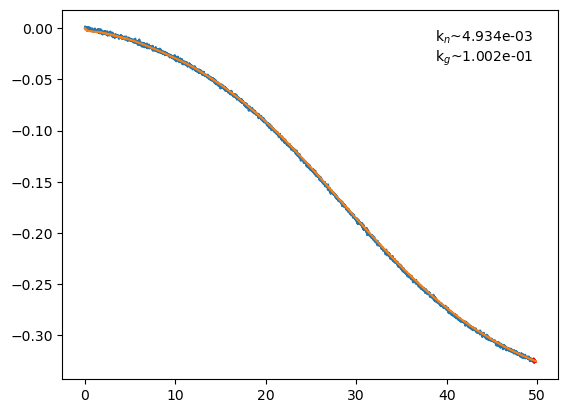

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.71it/s]


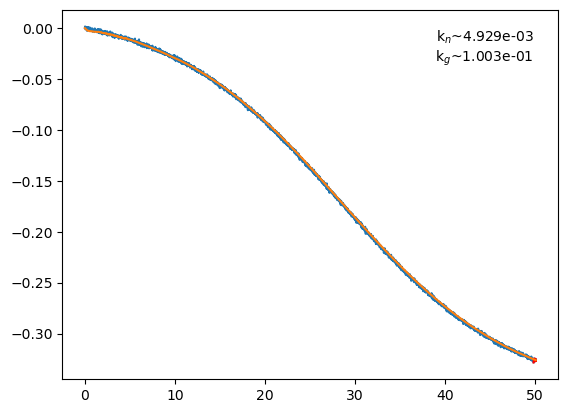

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.73it/s]


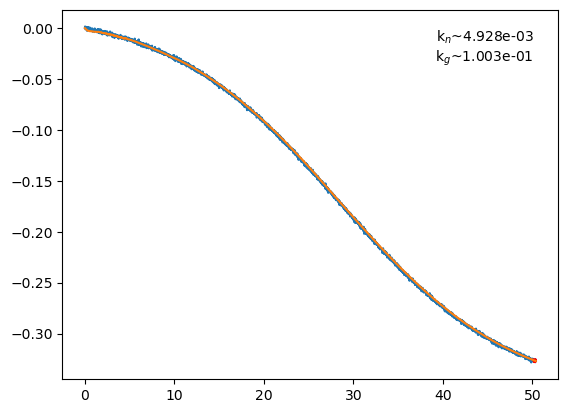

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.12it/s]


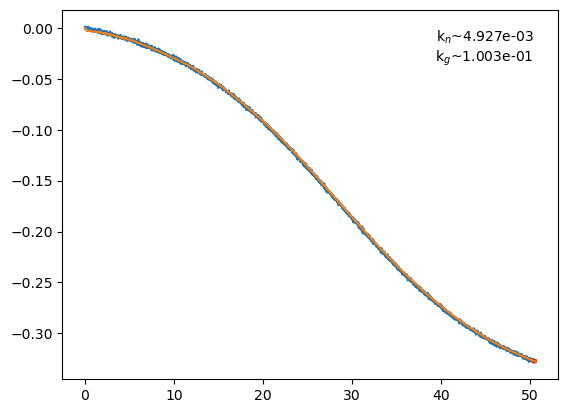

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.80it/s]


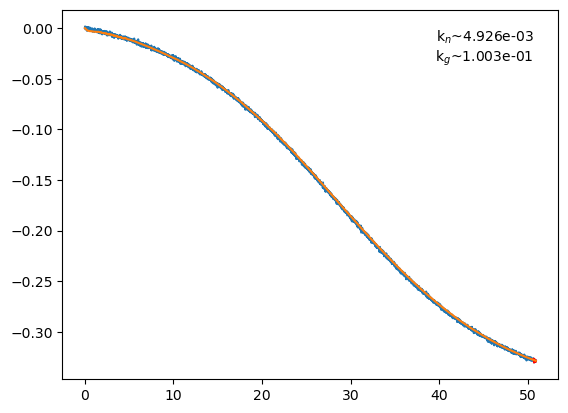

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.87it/s]


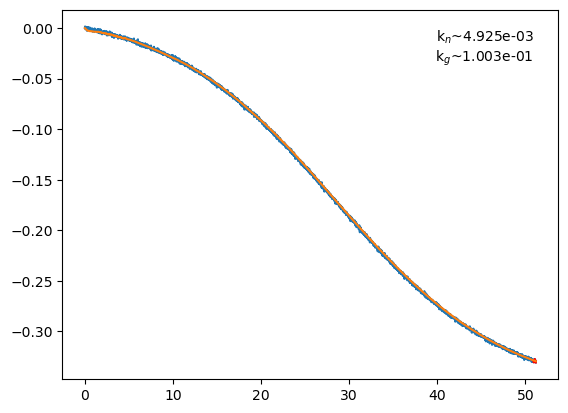

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.86it/s]


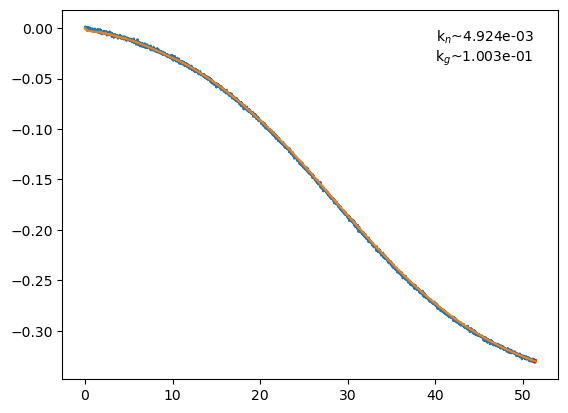

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 168.33it/s]


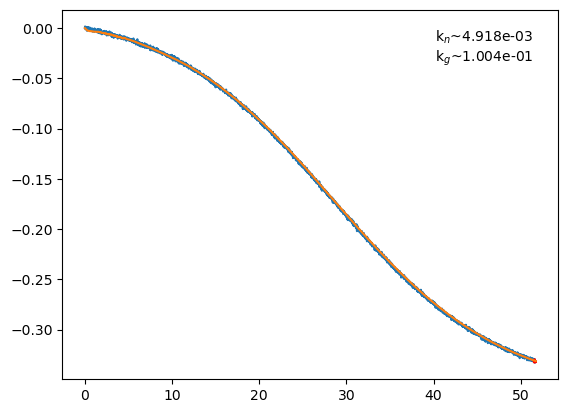

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 152.38it/s]


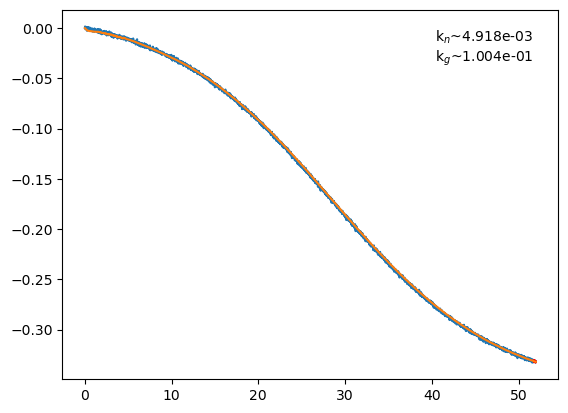

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.40it/s]


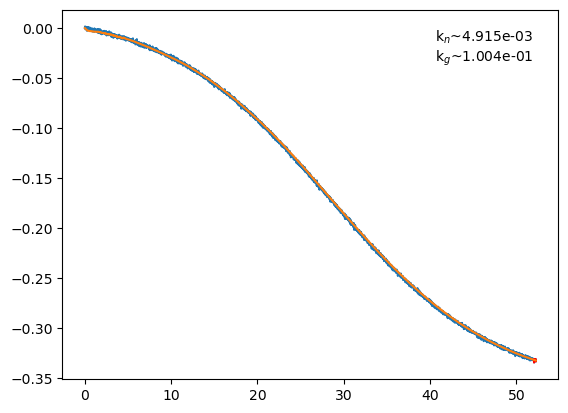

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.62it/s]


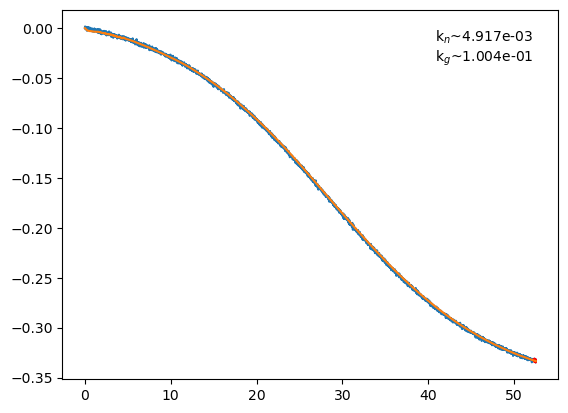

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.83it/s]


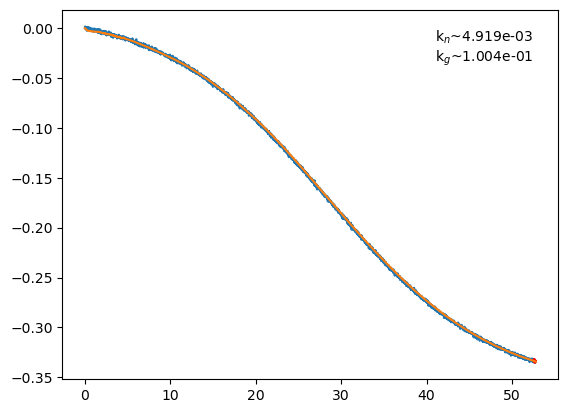

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.09it/s]


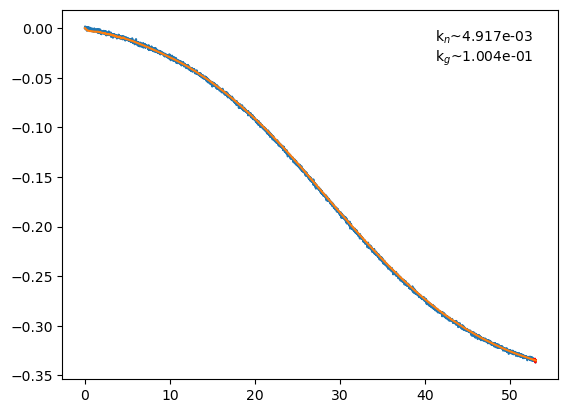

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.11it/s]


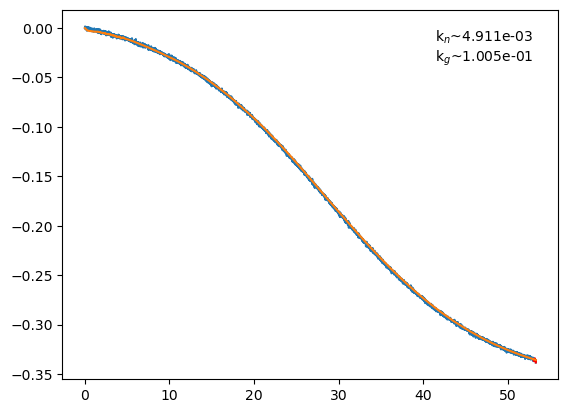

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 131.15it/s]


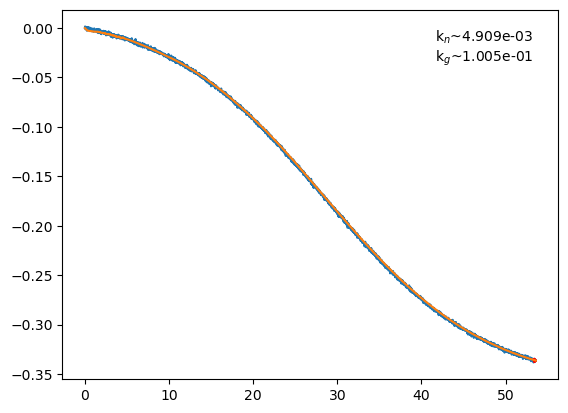

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.82it/s]


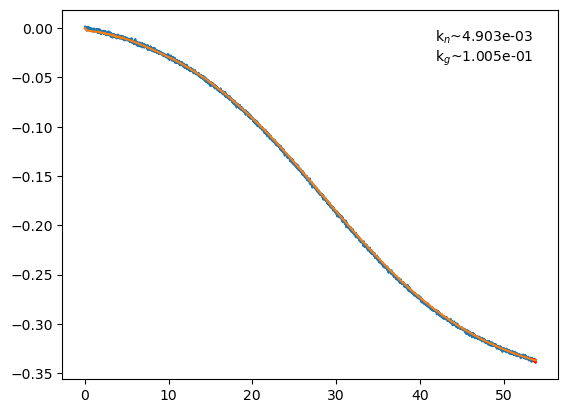

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 161.46it/s]


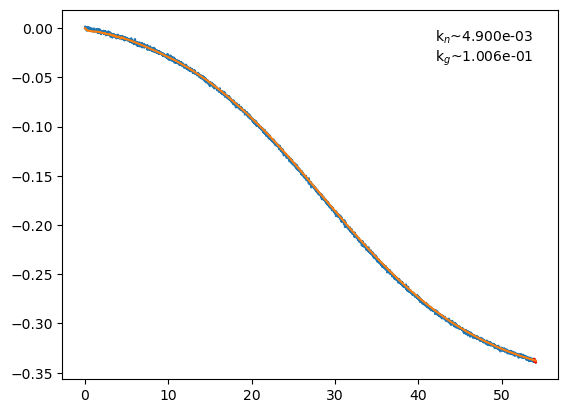

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 167.50it/s]


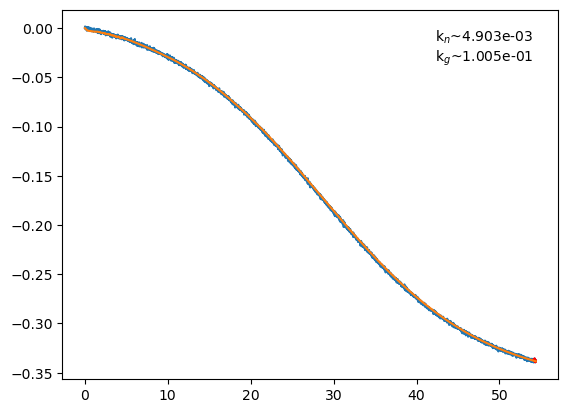

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 175.71it/s]


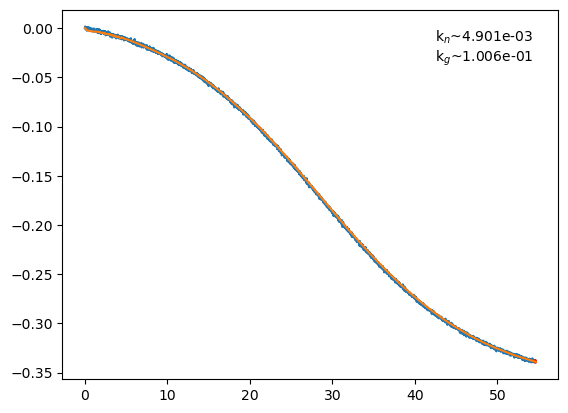

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.88it/s]


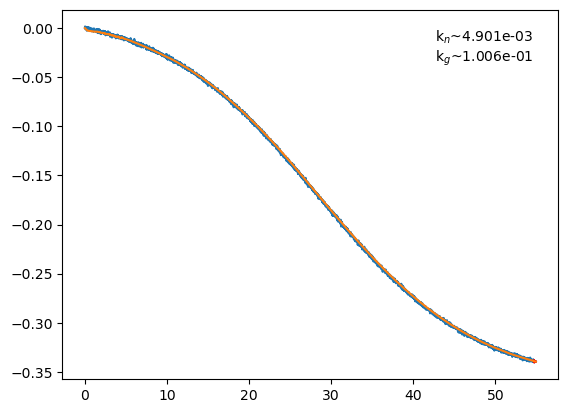

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.09it/s]


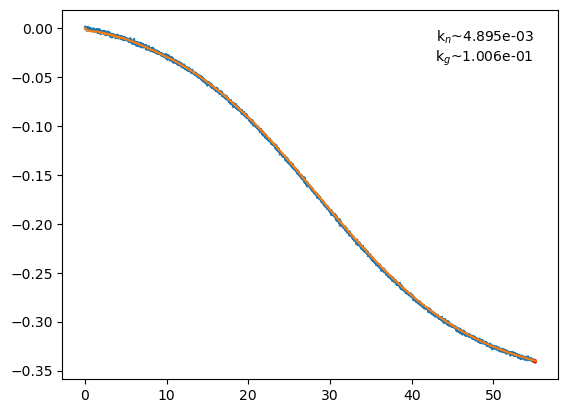

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.82it/s]


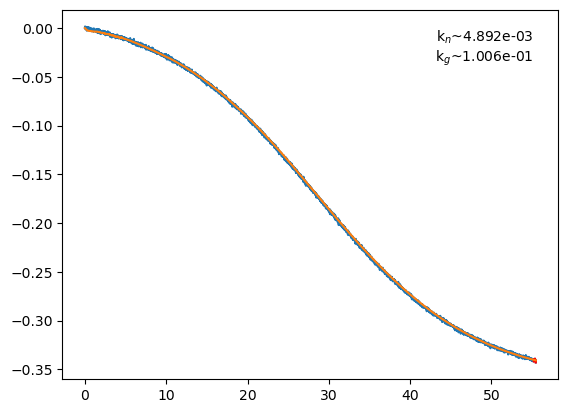

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.15it/s]


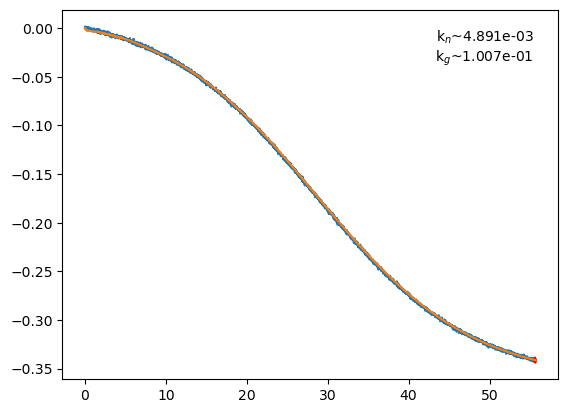

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.15it/s]


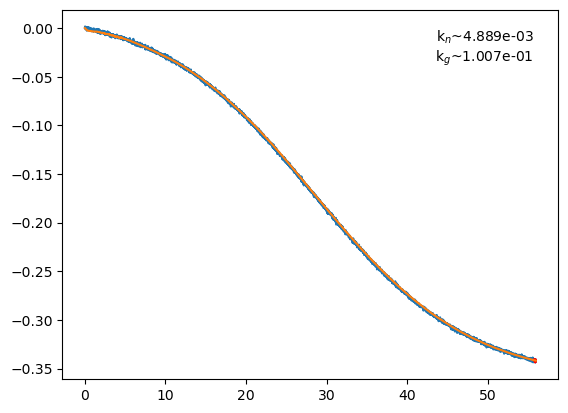

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.99it/s]


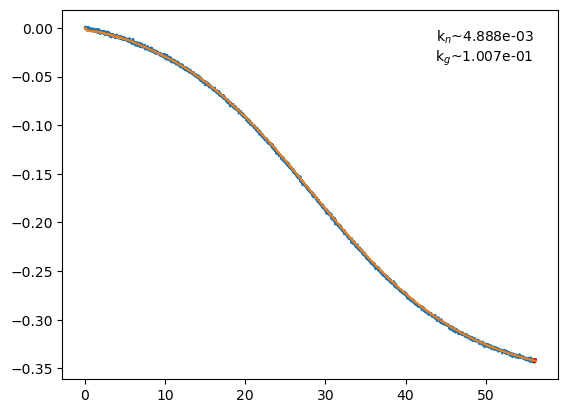

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 172.03it/s]


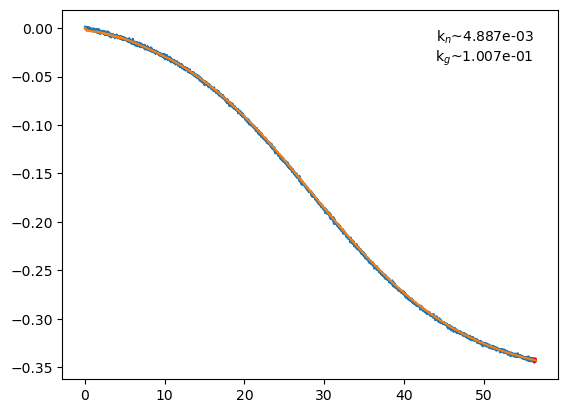

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.70it/s]


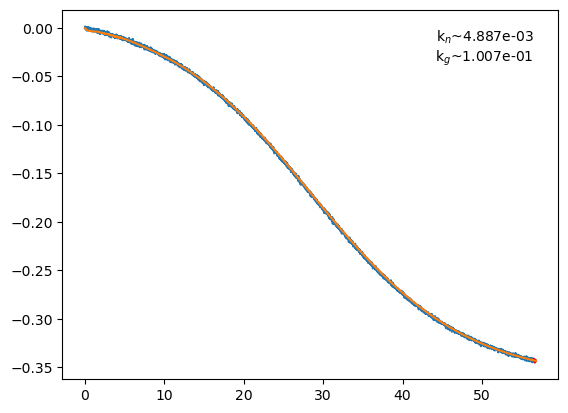

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.82it/s]


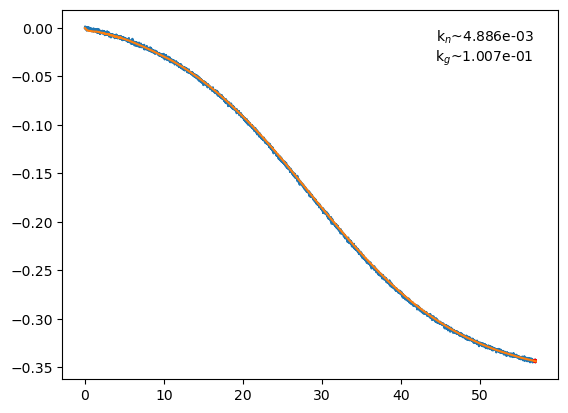

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.66it/s]


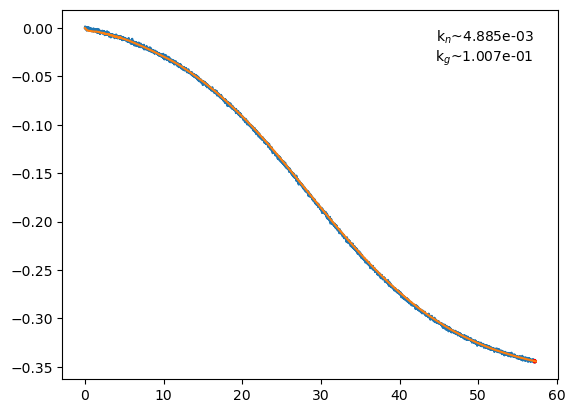

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.64it/s]


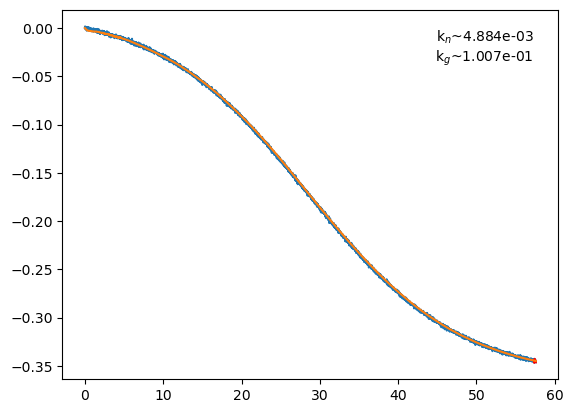

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.95it/s]


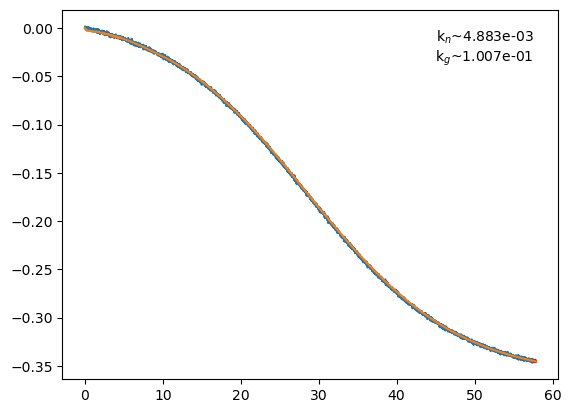

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.73it/s]


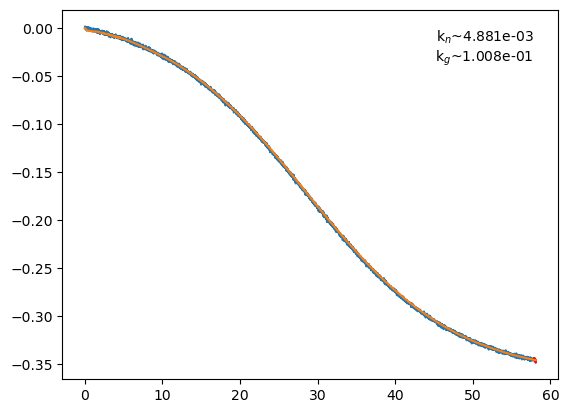

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 170.15it/s]


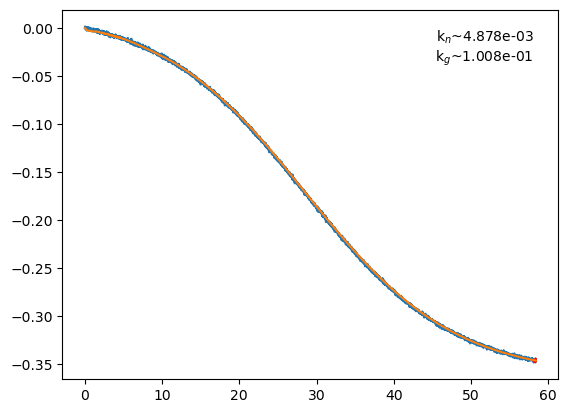

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 171.34it/s]


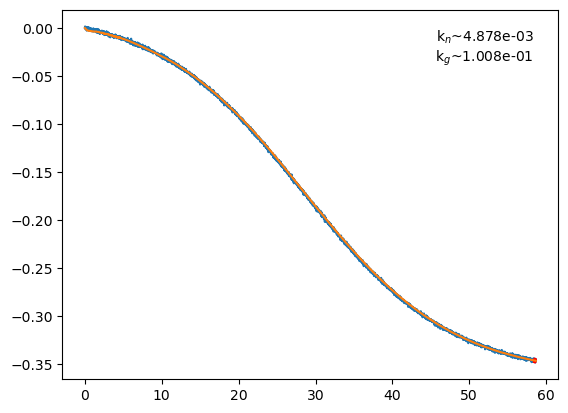

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.69it/s]


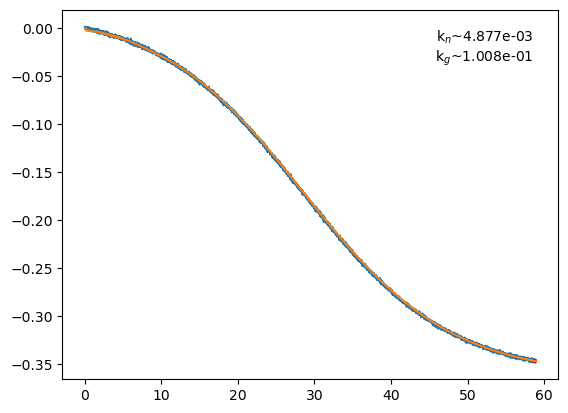

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 177.73it/s]


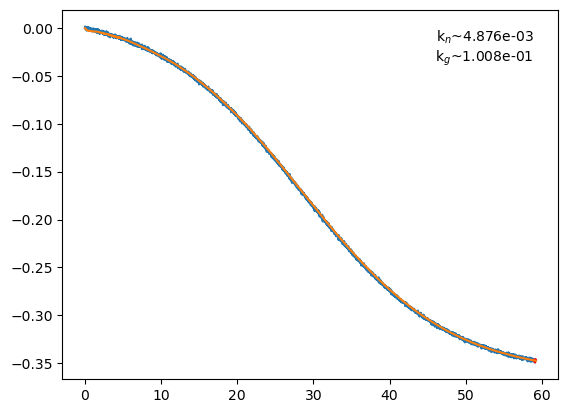

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.05it/s]


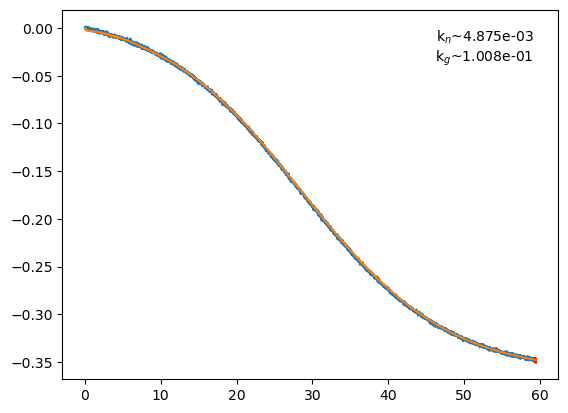

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.83it/s]


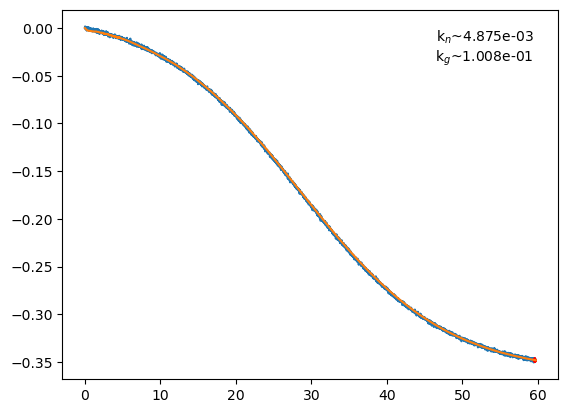

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 173.88it/s]


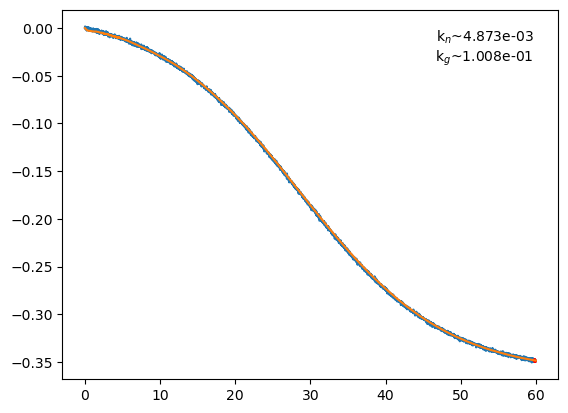

In [2]:
###############################################
# Set up the direct filter estimation algorithm
sigma = 0.01
eta = np.array([1e-6,1e-4])
initial_guess = np.array([0.001,0.01])
num_particles = 2000

pe = ParamEstim(model_type='monolayer',
                 initial_guess=initial_guess,
                 sigma=sigma,
                 eta=eta,
                 num_particles=num_particles,
                #play with using either stop_time or stop_contrast values
                 #stop_time=5, 
                 stop_contrast=-0.01
               )

###############################################
# Create synthetic data for testing using the monolayer growth model
time = np.arange(0,60,1/60)
k_n, k_gr = 5e-3, 1.0e-1

contrast = pe.monolayer_model(time, k_n, k_gr)
contrast = np.array([i+np.random.normal(0,0.001,1) for i in contrast])

###############################################

# Run an estimation on a simulated experiment, where data is updated 12 points
# at a time like the Keithly sourcemeter does.
chunk_size = 16 # each chunk contains 16 points per simulated "instrument read"
total_chunks = len(contrast)/chunk_size # the data is collected chunk by chunk in the for loop below

total_time = np.zeros(0)
for i in range(0, len(time), chunk_size):
    # "read" the new data from an instrument
    new_time, new_measurements = time[i:i+chunk_size], contrast[i:i+chunk_size]
    total_time = np.append(total_time,new_time) # keep track of the total time array, not needed if reading from a file

    # perform the paraemter estimation on the new data
    pe.step_estimation(new_time, new_measurements)
    # get predictions
    predictions = pe.predict()

    #plot the data with predictions
    plt.plot(pe.time,pe.measurements)
    plt.plot(new_time, new_measurements,'r')
    plt.plot(pe.time, np.array(predictions).reshape(-1))
    plt.text(0.95,0.95,"k$_n$~{:.3e}\n k$_g$~{:.3e}".format(pe.predictions[-1][0],pe.predictions[-1][1]),
             ha='right',va='top',transform=plt.gca().transAxes)
    plt.show()
    

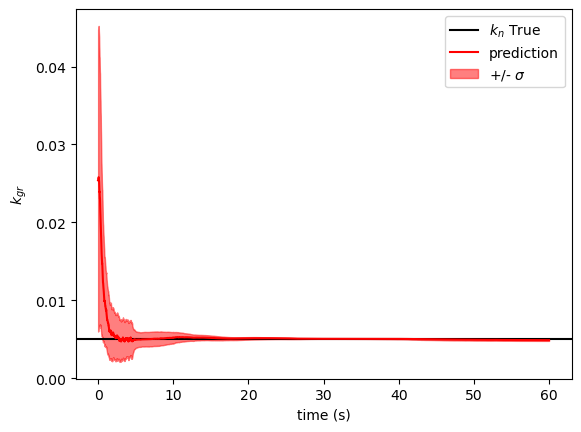

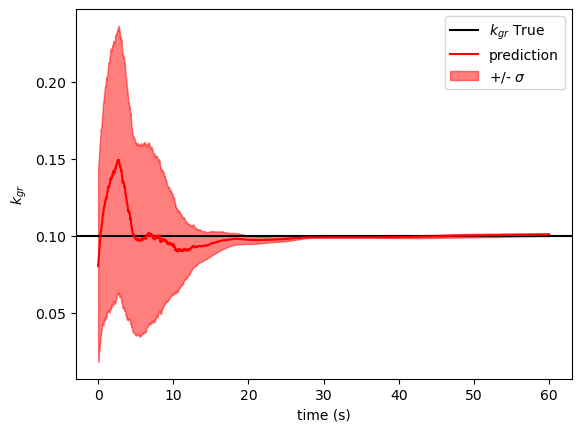

In [3]:
param_predictions = np.array(pe.predictions)
param_uncertainty = np.array(pe.uncertainties)

plt.axhline(k_n,c='k',label='$k_{n}$ True')
plt.plot(time,param_predictions[:,0],'r',label='prediction')
plt.fill_between(time,param_predictions[:,0]+param_uncertainty[:,0],
               param_predictions[:,0]-param_uncertainty[:,0],color='r',alpha=0.5,label=r'+/- $\sigma$')

#plt.ylim(0.002,0.005)
plt.xlabel('time (s)')
plt.ylabel('$k_{gr}$')
plt.legend()
plt.show()

plt.axhline(k_gr,c='k',label='$k_{gr}$ True')
plt.plot(time,param_predictions[:,1],'r',label='prediction')
plt.fill_between(time,param_predictions[:,1]+param_uncertainty[:,1],
               param_predictions[:,1]-param_uncertainty[:,1],color='r',alpha=0.5,label=r'+/- $\sigma$')

#plt.ylim(0.05,0.15)
plt.xlabel('time (s)')
plt.ylabel('$k_{gr}$')
plt.legend()
plt.show()